In [1]:
import itertools
import os
from pathlib import Path
import subprocess
import sys

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *
from math import log,inf,exp
import math

## Load MG1655

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')
BLAST_PATH = Path('../data/multi_strain_blast/')
OP_PATH = Path('../data/multistrain_blast_operon/')

In [3]:
origin = (3925743, 3925975)
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon_bitomekb.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

## Load multi strain bitome

In [4]:
bitomes_by_id = {}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')

for file in os.listdir(genome_dir):
    gb_id = file.split('.')[0]
    bitome = Bitome(Path(genome_dir, file),cid_boundaries=cid_boundaries )
    bitomes_by_id[bitome.reference_id] = bitome

In [5]:
[(b.description, b.reference_id) for b in bitomes_by_id.values()]

[('Escherichia coli BL21(DE3), complete genome', 'NC_012971.2'),
 ('Escherichia coli ATCC 8739, complete genome', 'NC_010468.1'),
 ('Escherichia coli CFT073, complete genome', 'NC_004431.1'),
 ('Escherichia coli str. K-12 substr. W3110 DNA, complete genome',
  'NC_007779.1'),
 ('Escherichia coli KO11FL, complete genome', 'NC_017660.1'),
 ('Escherichia coli 042 complete genome', 'NC_017626.1'),
 ('Escherichia coli O157:H7 str. Sakai, complete genome', 'NC_002695.1'),
 ('Escherichia coli W, complete genome', 'NC_017635.1')]

In [6]:
id_to_name = {
    'NC_004431.1': 'CFT073','NC_017626.1': '042','NC_007779.1': 'W3110',
    'NC_002695.1': 'O157:H7','NC_010468.1': 'Crooks','NC_017660.1': 'KO11FL',
    'NC_012971.2': 'BL21','NC_017635.1': 'W'
}
name_to_id = {}
for ID in id_to_name.keys():
    name_to_id[ id_to_name[ID]] = ID

In [7]:
strains_to_check = ['042','BL21','CFT073','Crooks','KO11FL','W','W3110'];

## Prepare FASTA of MG1655 Operons

In [8]:
with open(Path(OP_PATH, 'mg1655_ops.fasta'), 'w') as file_out:
    
    clean_op_table = mg1655.operon_table[(mg1655.operon_table['left'].notna()) & (mg1655.operon_table['right'].notna()) & 
                                    (mg1655.operon_table['strand'].notna()) ]
    
    for op_row in clean_op_table.itertuples():
        op_seq = str(mg1655.get_sequence(op_row.left, op_row.right, op_row.strand))
        file_out.write(f'>{op_row.Index}\n{op_seq}\n')

In [9]:
column_names = [
    'mg_op_id', 'strain_id', 'percent', 'align_length', 'n_mismatch', 'n_gapopen',
    'mg_start', 'mg_end', 'strain_start', 'strain_end', 'e_value', 'bit_score'
]

In [11]:
for strain_id, bitome in bitomes_by_id.items():
    
    # run the blast query
    subprocess.check_output(['blastn',
                             '-db', Path(BLAST_PATH, strain_id),
                             '-query', Path(OP_PATH, 'mg1655_ops.fasta'),
                             '-out', Path(OP_PATH, strain_id+'_operon_blast.csv'),
                             '-evalue', '0.001',
                             '-outfmt', '10',
                             '-num_threads', '4'])

In [19]:
multi_strain_op_rows = []

for strain_id, bitome in bitomes_by_id.items():
    
    # read in the file, add column names
    blast_report_df = pd.read_csv(Path(OP_PATH, strain_id+'_operon_blast.csv'), header=0, names=column_names)
    
    # move through and only keep the best match by TU
    for op_id, op_blast_df in blast_report_df.groupby('mg_op_id'):
     
        mg_op_info = mg1655.operon_table[mg1655.operon_table.index == op_id][[
            'name','left', 'right', 'strand']].drop_duplicates().T.squeeze()
        mg_op_len = int(mg_op_info['right'] - mg_op_info['left'] + 1)
        
        # best match starts at the same point as the MG Operon
        matches_from_start = op_blast_df[(op_blast_df['mg_start'] == 1) &
                                        (op_blast_df['mg_end'] == mg_op_len)]
        
        matches_from_start = matches_from_start.sort_values(by='mg_end', ascending=False)
        if not matches_from_start.empty:
            strain_start, strain_end = matches_from_start.iloc[0, :][['strain_start', 'strain_end']].values
            if strain_start < strain_end:
                strain_strand = 1
                length = strain_end - strain_start
                strain_left = strain_start
                strain_right = strain_end
            else:
                strain_strand = -1
                length = strain_start - strain_end
                strain_left = strain_end
                strain_right = strain_start
            
            op_match_row = [matches_from_start.iloc[0, :]['mg_op_id'],
                            int(mg_op_info['strand']),   str( mg_op_info['name'] ),
                           strain_id,  strain_strand, id_to_name[strain_id], length,strain_left,strain_right ]
            
            multi_strain_op_rows.append(op_match_row)
    
multi_strain_op_df = pd.DataFrame(multi_strain_op_rows, 
                                  columns=['mg_op_id', 'mg_strand','mg_op_name',
                                           'strain_id', 'strain_strand',
                                           'strain_name', 'strain_op_length','strain_left','strain_right'])

## create operon tables for bitome objects

In [ ]:
op_columns = ['locus_tag','name', 'left','right','strand']
operon_tables_byid = {}
for strain_id in list(id_to_name.keys()):
    sub_table = multi_strain_op_df[ multi_strain_op_df['strain_id'] == strain_id ]
    locus_tag = list(sub_table['mg_op_id'])
    name_list = list(sub_table['mg_op_name'])
    left_list = list(sub_table['strain_left'])
    right_list = list(sub_table['strain_right'])
    strand_list = list(sub_table['strain_strand'])
    operon_tables_byid[strain_id] = pd.DataFrame( list(zip(locus_tag,name_list,
                                                           left_list,right_list,strand_list) ) , columns = op_columns )

In [ ]:
for strain_id in list(id_to_name.keys()):
    temp_id = strain_id[0:-2] +'_' + strain_id[-1];
    temp_table = operon_tables_byid[strain_id]
    temp_table.to_csv('../data/Fur_multistrain_SN/'+temp_id+'/operon.csv')

##  Assign TU and operon

In [8]:
bitomes_by_id = {}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')

for file in os.listdir(genome_dir):
    gb_id = file.split('.')[0]
    bitome = Bitome(Path(genome_dir, file),cid_boundaries=cid_boundaries)
    b_id = bitome.reference_id
    tu_table_path = Path('../data/Fur_multistrain_SN/'+b_id[0:-2] +'_' + b_id[-1], 'tu.csv')
    op_table_path = Path('../data/Fur_multistrain_SN/'+b_id[0:-2] +'_' + b_id[-1], 'operon.csv')
    bitome = Bitome(Path(genome_dir, file),cid_boundaries=cid_boundaries,
                    tu_table= tu_table_path, operon_table = op_table_path)
    bitomes_by_id[bitome.reference_id] = bitome

In [9]:
strains = ['042','BL21','CFT073','Crooks','KO11FL','Sakai','W','W3110'];
Fur_multi_table = {}
for strain in strains:
    temp = pd.read_csv('../data/Fur_multistrain_SN/ecoli_'+strain+'_SN.csv')
    rm_list = []
    #filter too large sites
    for i in range(len(temp.index) ):
        if abs( temp['ChIP-exo End'][i] - temp['ChIP-exo Start'][i] ) > 50:
            rm_list.append(i)      
    temp = temp.drop(rm_list)
    temp = temp.dropna()
    temp = temp.reset_index()
    temp = temp.drop(columns=['index'])
    Fur_multi_table[strain] = temp

In [10]:
strains_to_check = ['042','BL21','CFT073','Crooks','KO11FL','W','W3110'];
for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    op_list = []
    op_name_list =[]
    for i in range(len(sn_table['ChIP-exo Start'])):
        start = list(sn_table['ChIP-exo Start'])[i]
        end = list(sn_table['ChIP-exo End'])[i]
        temp_table = bitomes_by_id[  name_to_id[strain_name] ].features_in_range(start,end)
        if len(temp_table.index) < 1:
            op_list.append(None)
            op_name_list.append(None)
        else:
            sub = temp_table[temp_table['type']=='operon']
            if len(sub['name']) < 1:
                op_list.append(None)
                op_name_list.append(None)
            else:
                op_list.append( sub.index[0])
                op_name_list.append( sub['name'][0] )
            
    sn_table['operon_id'] = op_list
    sn_table['operon_name'] = op_name_list
    sn_table = sn_table.dropna()
    sn_table = sn_table.reset_index()
    sn_table = sn_table.drop(columns=['index'])
    Fur_multi_table[strain_name] = sn_table

In [11]:
# resolve multiple chip results
for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    keep_list = []
    unique_ops = list( set(sn_table['operon_id'] ) )
    for op_id in unique_ops:
        temp = sn_table[sn_table['operon_id']==op_id]
        if len(temp['operon_id']) == 1:
            keep_list.append(  temp.index[0])
        else:
            max_index = list(temp['S/N ratio']).index( max( list(temp['S/N ratio']) ))
            keep_list.append( temp.index[max_index] )
    sn_table = sn_table.iloc[ keep_list ]
    sn_table = sn_table.reset_index()
    sn_table = sn_table.drop(columns=['index'])
    Fur_multi_table[strain_name] = sn_table

In [12]:
gene_tu_operon_map = pd.read_csv('../data/Fur_multistrain_SN/gene_tu_operon_mapping.csv')

In [13]:
def get_gene_byoperon( op_id):
    temp = gene_tu_operon_map[ gene_tu_operon_map['operon_id']==op_id]
    return list( set( temp['gene_id'] ) )


def get_geneTU( tu_name ):
    sub =  gene_tu_operon_map[  gene_tu_operon_map['tu_name'] == tu_name]
    if len(sub['gene_id']) < 1:
        return []
    else:
        return list( set( sub['gene_id'] ) )

In [14]:
TF_SN = pd.read_csv('../data/all_tf_data.csv')
TF_SN = TF_SN[['TF','SN_ratio','TU','start','stop','log_SN']]
mg1655_SN = TF_SN.iloc[0:143]

temp_table = mg1655_SN
keep_list = []
unique_tus = list( set(temp_table['TU'] ) )
for tu_id in unique_tus:
    sub = temp_table[temp_table['TU']==tu_id]
    if len(sub['TU']) == 1:
        keep_list.append(  sub.index[0])
    else:
        max_index = list(sub['log_SN']).index( max( list(sub['log_SN']) ))
        keep_list.append( sub.index[max_index] )
        
temp_table = temp_table.iloc[ keep_list ]
temp_table = temp_table.reset_index()
temp_table = temp_table.drop(columns=['index'])
mg1655_SN = temp_table

## assign TUs to the fur_info table

In [15]:
def get_tss(tu_id,strain_name):
    tu_table = bitomes_by_id[name_to_id[strain_name] ].tu_table
    sub = tu_table[tu_table.index == tu_id ]
    if len(sub['tss']) < 1:
        return 0
    else:
        return int( list( sub['tss'] )[0] )
    
    
def get_tu_byop( op_id, site, strain_name ):
    temp = gene_tu_operon_map[ gene_tu_operon_map['operon_id']==op_id]
    if len(temp['tu_id']) > 1:
        temp_dist = []
        for tu_id in list(temp['tu_id']):
            temp_tss = get_tss(tu_id,strain_name)
            if temp_tss == 0:
                temp_dist.append( inf )
            else:
                temp_dist.append( abs(temp_tss-site) )
        if temp_dist.count(inf) == len(temp_dist):
            return (None,None)
        else:
            min_index = temp_dist.index( min(temp_dist)  )
            return (list(temp['tu_id'])[ min_index ], list(temp['tu_name'])[ min_index ])
        
    elif len(temp['tu_id']) < 1:
        return (None,None)
    elif len(temp['tu_id']) == 1:
        tu_id = list(temp['tu_id'])[0]
        if get_tss(tu_id,strain_name) == 0:
            return (None,None)  
        return   (list(temp['tu_id'])[0], list(temp['tu_name'])[0])

In [16]:
for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    tu_list = []
    tu_name_list =[]
    for i in range(len(sn_table['ChIP-exo Start'])):
        start = list(sn_table['ChIP-exo Start'])[i]
        end = list(sn_table['ChIP-exo End'])[i]
        operon_id = list(sn_table['operon_id'])[i]
        tu_id, tu_name = get_tu_byop( operon_id, (start+end)/2, strain_name  )
        tu_list.append(tu_id)
        tu_name_list.append(tu_name)
            
    sn_table['tu_id'] = tu_list
    sn_table['tu_name'] = tu_name_list
    sn_table = sn_table.dropna()
    sn_table = sn_table.reset_index()
    sn_table = sn_table.drop(columns=['index'])
    Fur_multi_table[strain_name] = sn_table

In [17]:
tu_ids = []
for tu_name in list(mg1655_SN['TU']):
    sub = gene_tu_operon_map[  gene_tu_operon_map['tu_name'] == tu_name]
    if len(sub['tu_id']) == 1:
        tu_ids.append( list(sub['tu_id'])[0]  )
    elif len(sub['tu_id']) > 1:
        sub_mg1655 = mg1655_SN[mg1655_SN['TU']==tu_name]
        site = ( list(sub_mg1655['start'])[0] + list(sub_mg1655['stop'])[0] )/2
        temp_dist = []
        for tu_id in list(sub['tu_id']):
            temp_tss = mg1655.tu_table.loc[tu_id]['tss']
            temp_dist.append( abs(temp_tss-site) )
        min_index = temp_dist.index( min(temp_dist)  )
        tu_ids.append( list(sub['tu_id'])[ min_index ]  )
    else:
        tu_ids.append(None)
        
mg1655_SN['tu_id'] = tu_ids
mg1655_SN = mg1655_SN.dropna()
mg1655_SN = mg1655_SN.reset_index()
mg1655_SN = mg1655_SN.drop(columns=['index'])

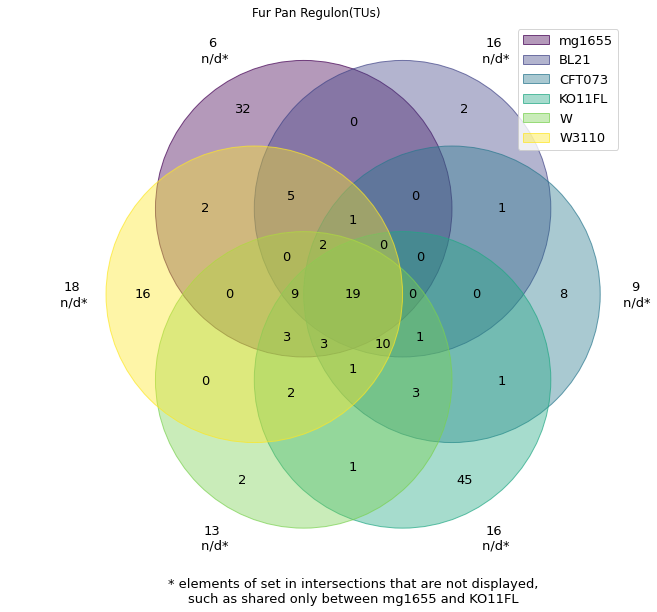

In [18]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']

from venn import pseudovenn
sets = {}
for strain_name in labels:
    if strain_name == 'mg1655':
        sets[strain_name] = set( mg1655_SN['TU'] )
    else:
        sets[strain_name] = set( Fur_multi_table[strain_name]['tu_name'] )
    
    
fig, ax = plt.subplots(1, figsize=(14,10))
pseudovenn(sets, ax=ax)
ax.set_title('Fur Pan Regulon(TUs)')
fig.savefig('../../../thesis_plots/fur_panregulon_tu.svg',dpi=150)

In [18]:
shared_tus = set(mg1655_SN['TU'])
for strain_name in ['BL21', 'CFT073', 'KO11FL', 'W', 'W3110']:
    sn_table = Fur_multi_table[strain_name]
    shared_tus = shared_tus & set( sn_table['tu_name'])
print( 'shared_TUs count = '+str(len(shared_tus)))

for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    core_list = []
    for i in range(len(sn_table['ChIP-exo Start'])):
        if list(sn_table['tu_name'])[i] in shared_tus:
            core_list.append(1)
        else:
            core_list.append(0)
    sn_table['core_regulon'] = core_list
    Fur_multi_table[strain_name] = sn_table

core_list = []
for i in range( len(mg1655_SN['TU']) ):
    if list(mg1655_SN['TU'])[i] in shared_tus:
        core_list.append(1)
    else:
        core_list.append(0)
mg1655_SN['core_regulon'] = core_list

shared_TUs count = 19


In [19]:
gene_sets = {}
gene_sets['mg1655'] = []
for i in range(len(mg1655_SN['TU'])):
    gene_sets['mg1655'] = gene_sets['mg1655'] + get_geneTU( list(mg1655_SN['TU'])[i] )
    
for strain_name in strains_to_check:
    sn_table = Fur_multi_table[strain_name]
    gene_sets[ strain_name ] = []
    for i in range( len(sn_table['tu_name']) ):
        gene_sets[ strain_name ] = gene_sets[ strain_name ]  + get_geneTU(  list(sn_table['tu_name'])[i] )  

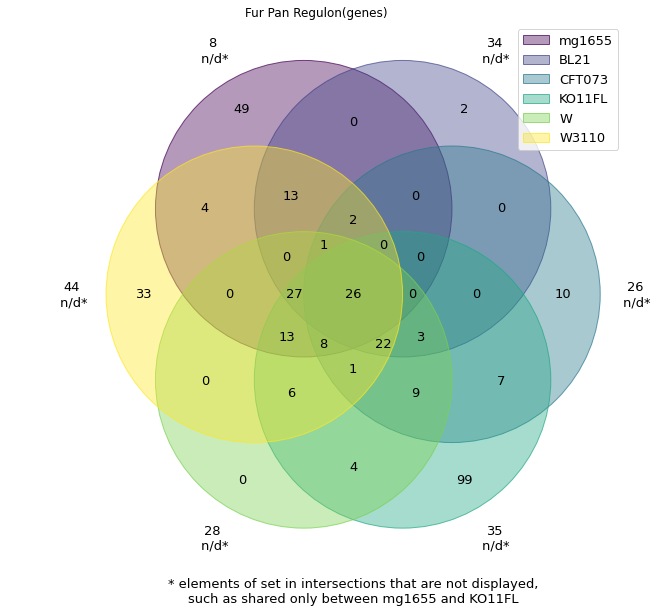

In [21]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']

from venn import pseudovenn
sets = {}
for strain_name in labels:
    sets[strain_name] = set( gene_sets[strain_name] )
    
    
fig, ax = plt.subplots(1, figsize=(14,10))
pseudovenn(sets, ax=ax)
ax.set_title('Fur Pan Regulon(genes)')
#plt.legend(labels, ncol=6)
fig.savefig('../../../thesis_plots/fur_panregulon_gene.svg',dpi=150)

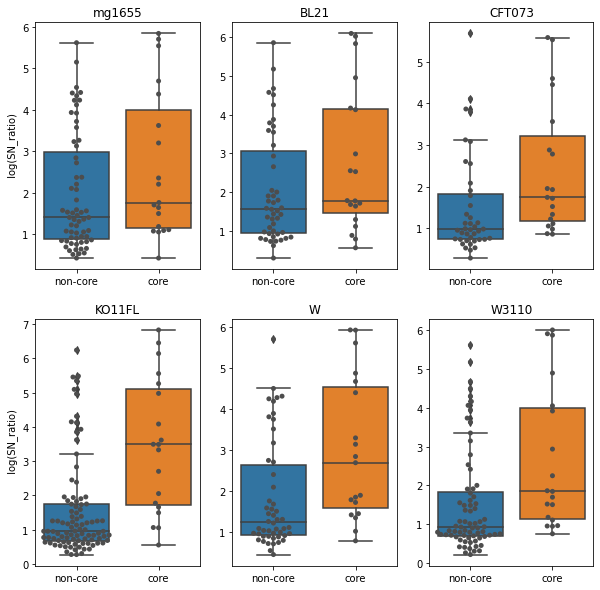

In [22]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
fig,axs = plt.subplots(2,3,figsize=(10,10))
for i in range(len(labels)):
    x_axis = int(i/3)
    y_axis = int(i%3)
    strain_name = labels[i]
    if strain_name == 'mg1655':
        log_sn_list = list(mg1655_SN['log_SN'])
        core = list(mg1655_SN['core_regulon'])
    else:
        log_sn_list = [ log(x) for x in list(Fur_multi_table[strain_name]['S/N ratio']) ]
        core = list(Fur_multi_table[strain_name]['core_regulon'])
        
    sns.boxplot(core,log_sn_list,ax = axs[x_axis][y_axis] )
    sns.swarmplot(core,log_sn_list,ax = axs[x_axis][y_axis], color = ".3")
    axs[x_axis][y_axis].set_title(strain_name)
    if y_axis == 0:
        axs[x_axis][y_axis].set_ylabel(' log(SN_ratio)')
    axs[x_axis][y_axis].set_xticklabels(['non-core','core'])

In [20]:
peak_h_incore = {}
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
list_shared_tus = list( shared_tus)
for strain_name in labels:
    peak_h_incore[ strain_name ] = []
    if strain_name == 'mg1655':
        for i in range( len( list_shared_tus)):
            row = mg1655_SN[ mg1655_SN['TU']==list_shared_tus[i] ]
            peak_h_incore[strain_name].append( list(row['log_SN'])[0] ) 
    else:
        for i in range( len( shared_tus)):
            sn_table = Fur_multi_table[strain_name]
            row = sn_table[ sn_table['tu_name'] == list_shared_tus[i] ]
            peak_h_incore[strain_name].append( log( list(row['S/N ratio']) [0]) )

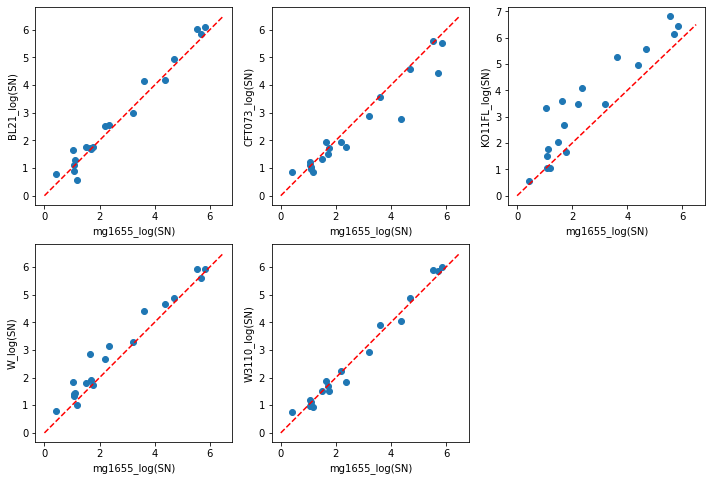

In [22]:
fig,axs = plt.subplots(2,3,figsize=(12,8))
for i in range(5):
    x_axis = int(i/3)
    y_axis = int(i%3)
    strain_name = labels[i+1]
    mg_sn = peak_h_incore['mg1655']
    strain_sn = peak_h_incore[strain_name]
    axs[x_axis][y_axis].scatter(mg_sn, strain_sn)
    axs[x_axis][y_axis].set_xlabel('mg1655_log(SN)')
    axs[x_axis][y_axis].set_ylabel(strain_name+'_log(SN)')
    axs[x_axis][y_axis].plot([0, 6.5], [0, 6.5], ls='--',color='r')
axs[-1][-1].axis('off')
fig.savefig('../../../thesis_plots/multistrain_SN.svg',dpi=150)

In [21]:
shared_genes = set(gene_sets['mg1655'])
for strain_name in ['BL21', 'CFT073', 'KO11FL', 'W', 'W3110']:
    shared_genes = shared_genes & set(gene_sets[strain_name])
print( 'shared_genes count = '+str(len(shared_genes)))
import ast
im_info = pd.read_csv('../data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

shared_genes count = 26


dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

In [22]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
unq_reg= {}
for strain_name in labels:
    if strain_name == 'mg1655':
        unq_reg[strain_name] = set( mg1655_SN['TU'] )
    else:
        unq_reg[strain_name] = set( Fur_multi_table[strain_name]['tu_name'] )
    
    for s_name in labels:
        if s_name == strain_name:
            continue
        if s_name == 'mg1655':
            temp = set( mg1655_SN['TU'] )
        else:
            temp = set( Fur_multi_table[s_name]['tu_name'] )
        
        unq_reg[strain_name] = unq_reg[strain_name] - temp

for strain_name in labels:
    print(strain_name+'_unique regulon: n = '+ str(len(unq_reg[strain_name])) )

mg1655_unique regulon: n = 32
BL21_unique regulon: n = 2
CFT073_unique regulon: n = 8
KO11FL_unique regulon: n = 45
W_unique regulon: n = 2
W3110_unique regulon: n = 16


In [23]:
for strain_name in labels:
    regulon_region = []
    if strain_name == 'mg1655':
        sn_table = mg1655_SN
        for tu_name in list( sn_table['TU']):
            if tu_name in unq_reg[strain_name]:
                regulon_region.append('unique')
            elif tu_name in shared_tus:
                regulon_region.append('core')
            else:
                regulon_region.append('accessory')
        mg1655_SN['regulon_region'] = regulon_region
    else:
        sn_table = Fur_multi_table[strain_name]
        for tu_name in list( sn_table['tu_name']):
            if tu_name in unq_reg[strain_name]:
                regulon_region.append('unique')
            elif tu_name in shared_tus:
                regulon_region.append('core')
            else:
                regulon_region.append('accessory')
            
        Fur_multi_table[strain_name]['regulon_region'] = regulon_region 

In [24]:
from scipy.stats import f_oneway
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
pvalues = {}
for strainname in labels:
    sn = {'core':[],'accessory':[],'unique':[]}
    if strainname == 'mg1655':
        for i in range(len(mg1655_SN['log_SN'])):
            sn[ mg1655_SN['regulon_region'][i]].append( mg1655_SN['log_SN'][i] )
    else:
        for i in range(len(Fur_multi_table[strainname]['S/N ratio'])):
            sn[  Fur_multi_table[strainname]['regulon_region'][i] ].append( Fur_multi_table[strainname]['S/N ratio'][i] )
    
    pvalues[strainname]=f_oneway(sn['core'],sn['accessory'],sn['unique']).pvalue
print(pvalues)

{'mg1655': 0.2390010424601861, 'BL21': 0.10155085707979018, 'CFT073': 0.20449544859338398, 'KO11FL': 0.000120760772994271, 'W': 0.026338032679553643, 'W3110': 0.006513253398980005}


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

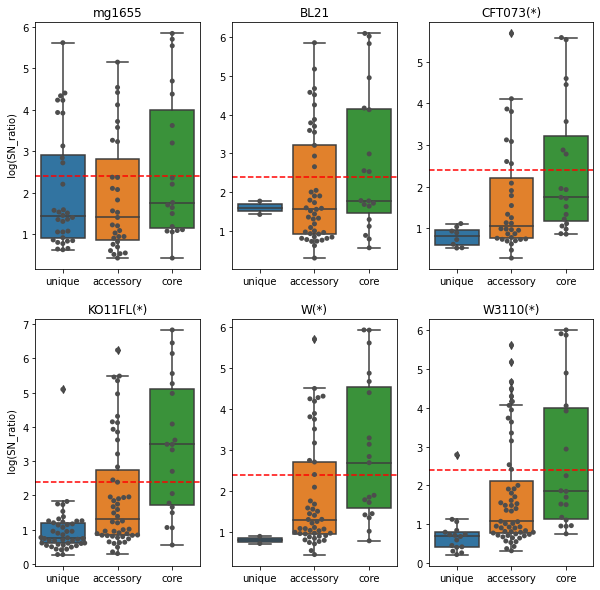

In [27]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
fig,axs = plt.subplots(2,3,figsize=(10,10))
for i in range(len(labels)):
    x_axis = int(i/3)
    y_axis = int(i%3)
    strain_name = labels[i]
    if strain_name == 'mg1655':
        log_sn_list = list(mg1655_SN['log_SN'])
        regulon_region = list(mg1655_SN['regulon_region'])
    else:
        log_sn_list = [ log(x) for x in list(Fur_multi_table[strain_name]['S/N ratio']) ]
        regulon_region = list(Fur_multi_table[strain_name]['regulon_region'])
        
    sns.boxplot( regulon_region ,log_sn_list,ax = axs[x_axis][y_axis], order=["unique", "accessory","core"] )
    sns.swarmplot(regulon_region ,log_sn_list,ax = axs[x_axis][y_axis], order=["unique", "accessory","core"],color = ".3")
    if strain_name in ['CFT073', 'KO11FL', 'W', 'W3110']:
        axs[x_axis][y_axis].set_title(strain_name+'(*)')
    else:
        axs[x_axis][y_axis].set_title(strain_name)
                                      
    axs[x_axis][y_axis].axhline(y= 2.4, color = 'r', ls = '--')
    if y_axis == 0:
        axs[x_axis][y_axis].set_ylabel(' log(SN_ratio)')
fig.savefig('../../../thesis_plots/SN_panregulon_distribution.svg',dpi=150)

In [65]:
def get_avg_tpm( tu_id ):
    tpm_list = []
    sub = gene_tu_operon_map[ gene_tu_operon_map['tu_id'] == tu_id ]
    genes = list( set( sub['gene_id'] ) )
    for g in genes:
        tpm = list(mg1655.gene_table[ mg1655.gene_table.index == g ]['tpm'])
        if not( math.isnan( list(tpm)[0] ) ):
            tpm_list.append( list(tpm)[0] )
                
    if len(tpm_list) >= 1:
        avg = sum(tpm_list)/len(tpm_list)
    else:
        avg = 0
    return avg

In [32]:
temp = []
for tu_id in list( mg1655_SN['tu_id']):
    if get_avg_tpm(tu_id) != 0:
        temp.append( log(get_avg_tpm(tu_id) )  )
    else:
        temp.append( -1  )
mg1655_SN['log_tpm'] = temp

Text(0.5, 1.0, 'MG1655')

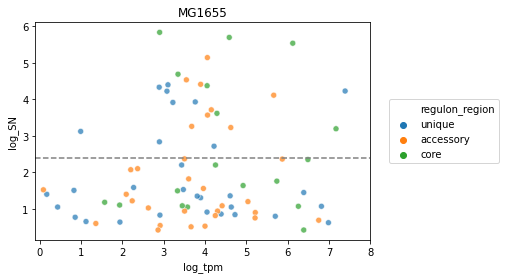

In [36]:
sns.scatterplot( data =mg1655_SN, x= 'log_tpm', y = 'log_SN', hue = 'regulon_region',
                alpha = 0.7,hue_order =['unique','accessory','core'] )
plt.xlim([-0.1,8])
plt.axhline(y=2.4,ls = '--', color = 'grey')
plt.legend( loc = 'center right',bbox_to_anchor=(1.4,0.5))
plt.title('MG1655')

In [60]:
# from Jonathan Monk's paper in 2016
tpm_pd = pd.read_csv('../data/Fur_multistrain_SN/tpm_multistrain.csv')
b_ids = []
for gname in list(tpm_pd['Gene']):
    sub = gene_tu_operon_map[ gene_tu_operon_map['gene_name'] == gname ]
    if len( sub['gene_id'] ) < 1:
        bid = None
    else:
        bid = list(sub['gene_id'])[0]
    b_ids.append(bid)
tpm_pd['gene_id'] = b_ids
tpm_pd = tpm_pd.dropna()
tpm_pd = tpm_pd.reset_index()
tpm_pd = tpm_pd.drop(columns=['index'])
tpm_pd['BL21'] = list( np.average( np.array([list(tpm_pd['BL21/Ana_1 '] ),
                                       list(tpm_pd['BL21/Ana_2 ']),list(tpm_pd['BL21/Ana_3'])]) , axis=0) )
tpm_pd['MG1655'] = list( np.average( np.array([list(tpm_pd['MG1655/Ana_1'] ),
                                       list(tpm_pd['MG1655/Ana_2']),list(tpm_pd['MG1655/Ana_3'])]) , axis=0) )
tpm_pd['W'] = list( np.average( np.array([list(tpm_pd['W/Ana_1 '] ),
                                       list(tpm_pd['W/Ana_2 ']),list(tpm_pd['W/Ana_3'])]) , axis=0) )
tpm_pd['W3110'] = list( np.average( np.array([list(tpm_pd['W3110/Ana_1 '] ),
                                       list(tpm_pd['W3110/Ana_2 ']),list(tpm_pd['W3110/Ana_3'])]) , axis=0) )

tpm_pd = tpm_pd[['Gene','gene_id','BL21','MG1655','W3110','W'] ]
tpm_pd.head()

,Gene,gene_id,BL21,MG1655,W3110,W
0,aaeA,b3241,53.666667,23.666667,16.000000,38.333333
1,aaeB,b3240,88.000000,36.333333,33.333333,111.000000
2,aaeR,b3243,80.666667,114.666667,78.000000,110.333333
3,aaeX,b3242,11.666667,4.666667,7.000000,6.666667
4,aas,b2836,115.333333,127.000000,144.666667,136.000000


In [70]:
def get_avg_tpm_2( tu_id, strain_name ):
    tpm_list = []
    sub = gene_tu_operon_map[ gene_tu_operon_map['tu_id'] == tu_id ]
    genes = list( set( sub['gene_id'] ) )
    for g in genes:
        tpm = list( tpm_pd[ tpm_pd['gene_id']==g ][ strain_name ] )
        if len(tpm) > 0:
            tpm_list.append( tpm[0] )
                
    if len(tpm_list) >= 1:
        avg = sum(tpm_list)/len(tpm_list)
    else:
        avg = 0
    return avg


tpm_sn_pd = {'MG1655': mg1655_SN, 'BL21':Fur_multi_table['BL21'] ,
             'W3110': Fur_multi_table['W3110'], 'W':Fur_multi_table['W']}
for strain_name in tpm_sn_pd.keys():
    sn_table = tpm_sn_pd[ strain_name ]
    temp = []
    for tu_id in list( sn_table['tu_id']):
        
        if get_avg_tpm_2(tu_id,strain_name) != 0:
            temp.append( log( get_avg_tpm_2(tu_id,strain_name) )  )
        else:
            temp.append( -1  )
    sn_table['log_tpm_ana'] = temp
    tpm_sn_pd[ strain_name ] = sn_table

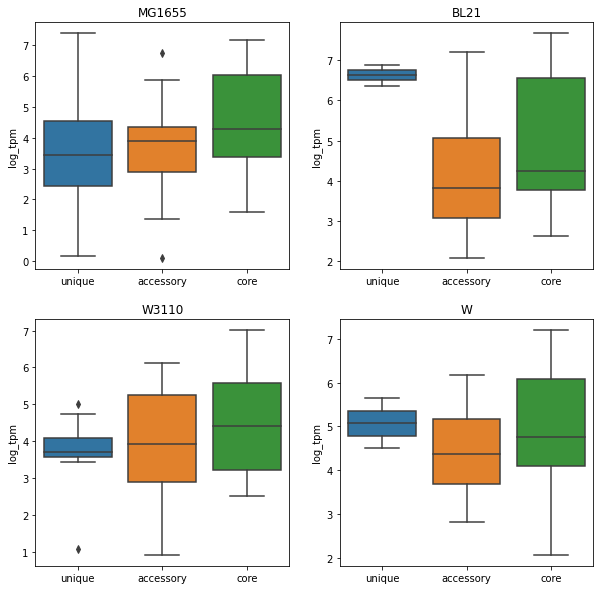

In [87]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
for i in range(len(tpm_sn_pd.keys())):
    strain_name = list(tpm_sn_pd.keys() )[i]
    x_axis = int(i/2)
    y_axis = int(i%2)
    if strain_name =='MG1655':
        var = 'log_tpm'
    else:
        var = 'log_tpm_ana'
    log_tpm = []
    regulon_region  = []
    for j in range(len( list( tpm_sn_pd[strain_name][var] ) )):
        if list( tpm_sn_pd[strain_name][var] )[j] != -1:
            log_tpm.append(  list( tpm_sn_pd[strain_name][var] )[j] )
            regulon_region.append(  list(tpm_sn_pd[strain_name]['regulon_region'])[j] )
         
    
    sns.boxplot( regulon_region ,log_tpm,
                ax = axs[x_axis][y_axis], order=["unique", "accessory","core"])
    
    axs[x_axis][y_axis].set_title(strain_name)
    axs[x_axis][y_axis].set_ylabel('log_tpm')

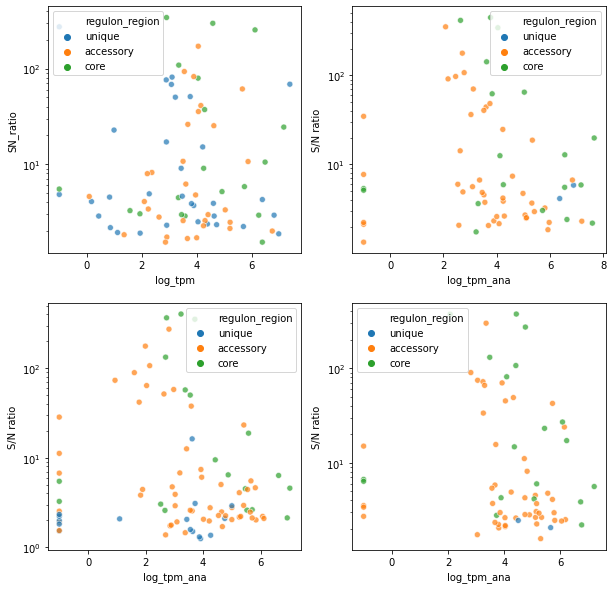

In [91]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
for i in range(len(tpm_sn_pd.keys())):
    strain_name = list(tpm_sn_pd.keys() )[i]
    x_axis = int(i/2)
    y_axis = int(i%2)
    if strain_name =='MG1655':
        xvar = 'log_tpm'
        yvar = 'SN_ratio'
    else:
        xvar = 'log_tpm_ana'
        yvar = 'S/N ratio'
    
    sns.scatterplot( data = tpm_sn_pd[strain_name], x= xvar , y = yvar, hue = 'regulon_region',
                alpha = 0.7,ax = axs[x_axis][y_axis],hue_order =['unique','accessory','core']  )
    axs[x_axis][y_axis].set_yscale('log')

# compute motif scores and correlation with SN

In [25]:
pwm_db = rpwm('../data/motif_pwm_db.txt')
pwm_im = rlogodds('../data/motif_logodds.txt')

In [27]:
N_up = 150
N_down = 30

feature_table = {}
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
        
    feature = []
    bitome = bitomes_by_id[  name_to_id[strain_name] ]
    tu_table = bitome.tu_table
    for i in range(len(tu_table['name'])):
        data = {}
        data['tu_id'] = tu_table.index[i]
        data['tu_name'] = list(tu_table['name'])[i]
        temp_tss = int(tu_table['tss'][i])
        data['tss'] = temp_tss
        if temp_tss < 150:
            continue
        strand = int(tu_table['strand'][i])
        data['strand'] = strand
        data.update(  motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,pwm_db , 'Fur', False ) )
        data.update(  motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,pwm_im , 'Fur-1', True ) )
        data.update(  motif_match_noshape( temp_tss , strand , N_up ,N_down,bitome ,pwm_im , 'Fur-2', True ) )
        feature.append( data )
    feature_table[ strain_name] = pd.DataFrame( feature )

In [28]:
merge_table = {}
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
    f_table = feature_table[strain_name]
    sn_table = Fur_multi_table[strain_name]
    rm_list = []
    for i in range(len(f_table['tu_id'])):
        if f_table['tu_id'][i] not in list(sn_table['tu_id']):
            rm_list.append(i)
    f_table= f_table.drop(rm_list)
    f_table = f_table.reset_index()
    f_table= f_table.drop(columns=['index'])
    sn_table = sn_table.merge(f_table, on='tu_id')
    merge_table[strain_name] = sn_table

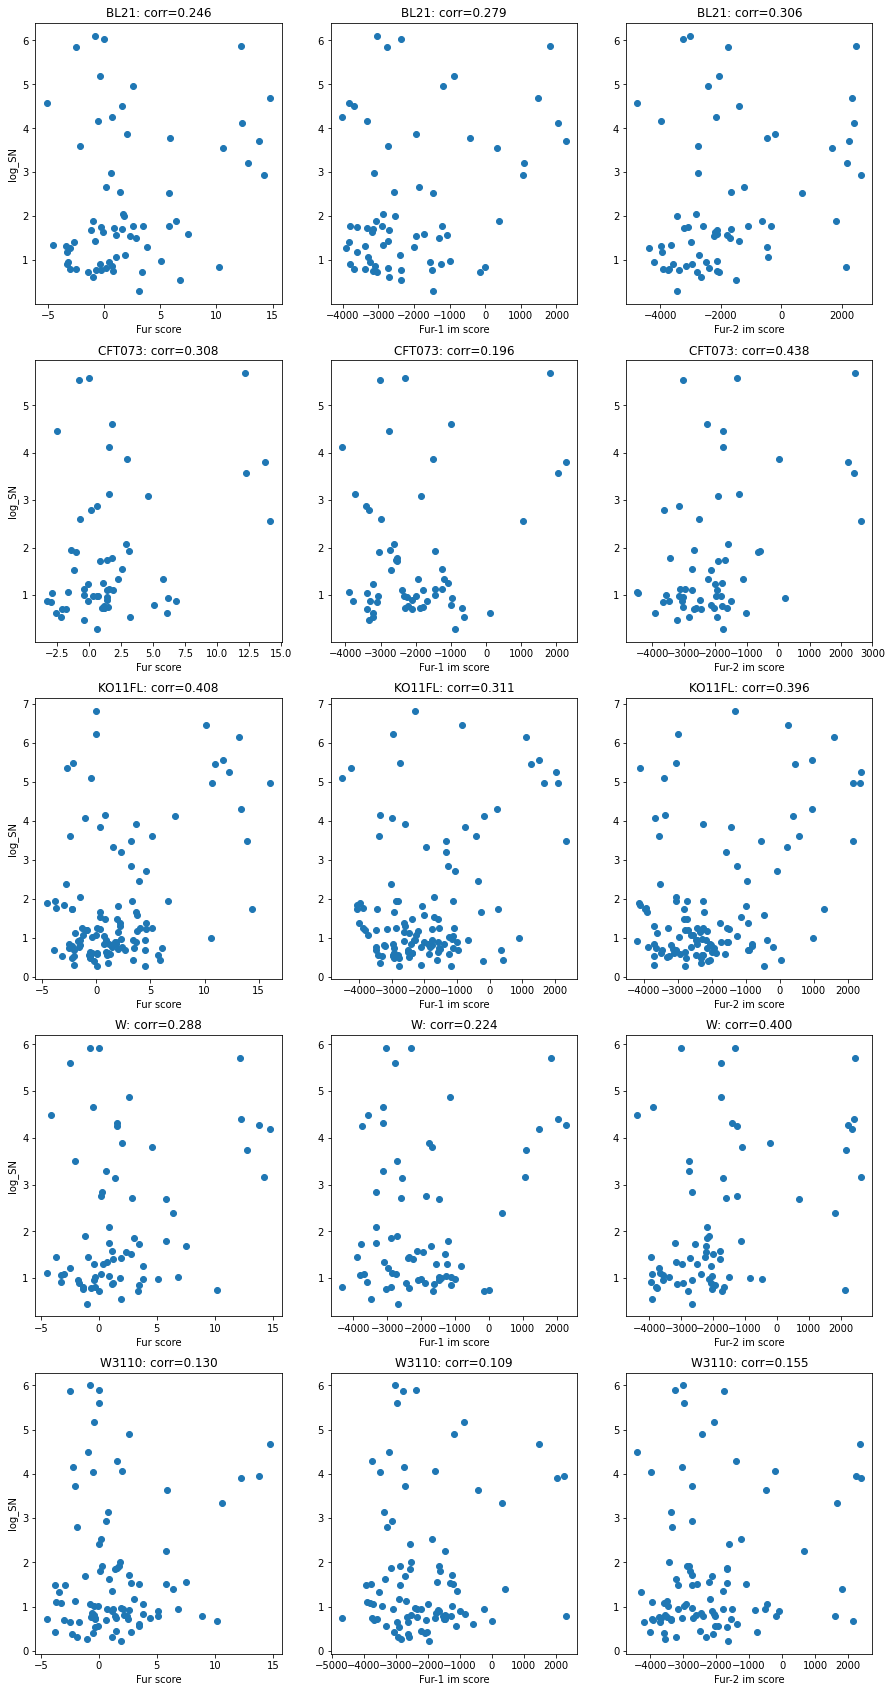

In [29]:
f_list = ['Fur score','Fur-1 im score','Fur-2 im score']
fig,axs = plt.subplots(5,3,figsize=(15,30))
for x in range(5):
    for y in range(len(f_list)):
        strain_name = labels[x+1]
        f_name = f_list[y]
        sn = list(merge_table[strain_name]['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(merge_table[strain_name][f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ': corr='+corr_txt)
        axs[x][y].set_xlabel( f_name )
        if y == 0:
            axs[x][y].set_ylabel('log_SN')

### try new motifs

In [35]:
fur_motifs = rlogodds('../data/Fur_multistrain_SN/Fur_multi_motif.txt')

In [36]:
feature_table = {}
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
        
    feature = []
    bitome = bitomes_by_id[  name_to_id[strain_name] ]
    tu_table = bitome.tu_table
    for i in range(len(tu_table['name'])):
        data = {}
        data['tu_id'] = tu_table.index[i]
        data['tu_name'] = list(tu_table['name'])[i]
        temp_tss = int(tu_table['tss'][i])
        if temp_tss < 150:
            continue
        strand = int(tu_table['strand'][i])
        data['strand'] = strand
        data['tss'] = temp_tss
        for motif in fur_motifs.keys():
            result = motif_match_noshape( temp_tss , strand , N_up ,N_down, bitome ,fur_motifs ,motif, False )
            result.pop( motif+' Matched Motif')
            data.update(result)
            
        feature.append( data )
    feature_table[ strain_name] = pd.DataFrame( feature )

merge_table_1 = {}
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
    f_table = feature_table[strain_name]
    sn_table = Fur_multi_table[strain_name]
    rm_list = []
    for i in range(len(f_table['tu_id'])):
        if f_table['tu_id'][i] not in list(sn_table['tu_id']):
            rm_list.append(i)
    f_table= f_table.drop(rm_list)
    f_table = f_table.reset_index()
    f_table= f_table.drop(columns=['index'])
    sn_table = sn_table.merge(f_table, on='tu_id')
    merge_table_1[strain_name] = sn_table

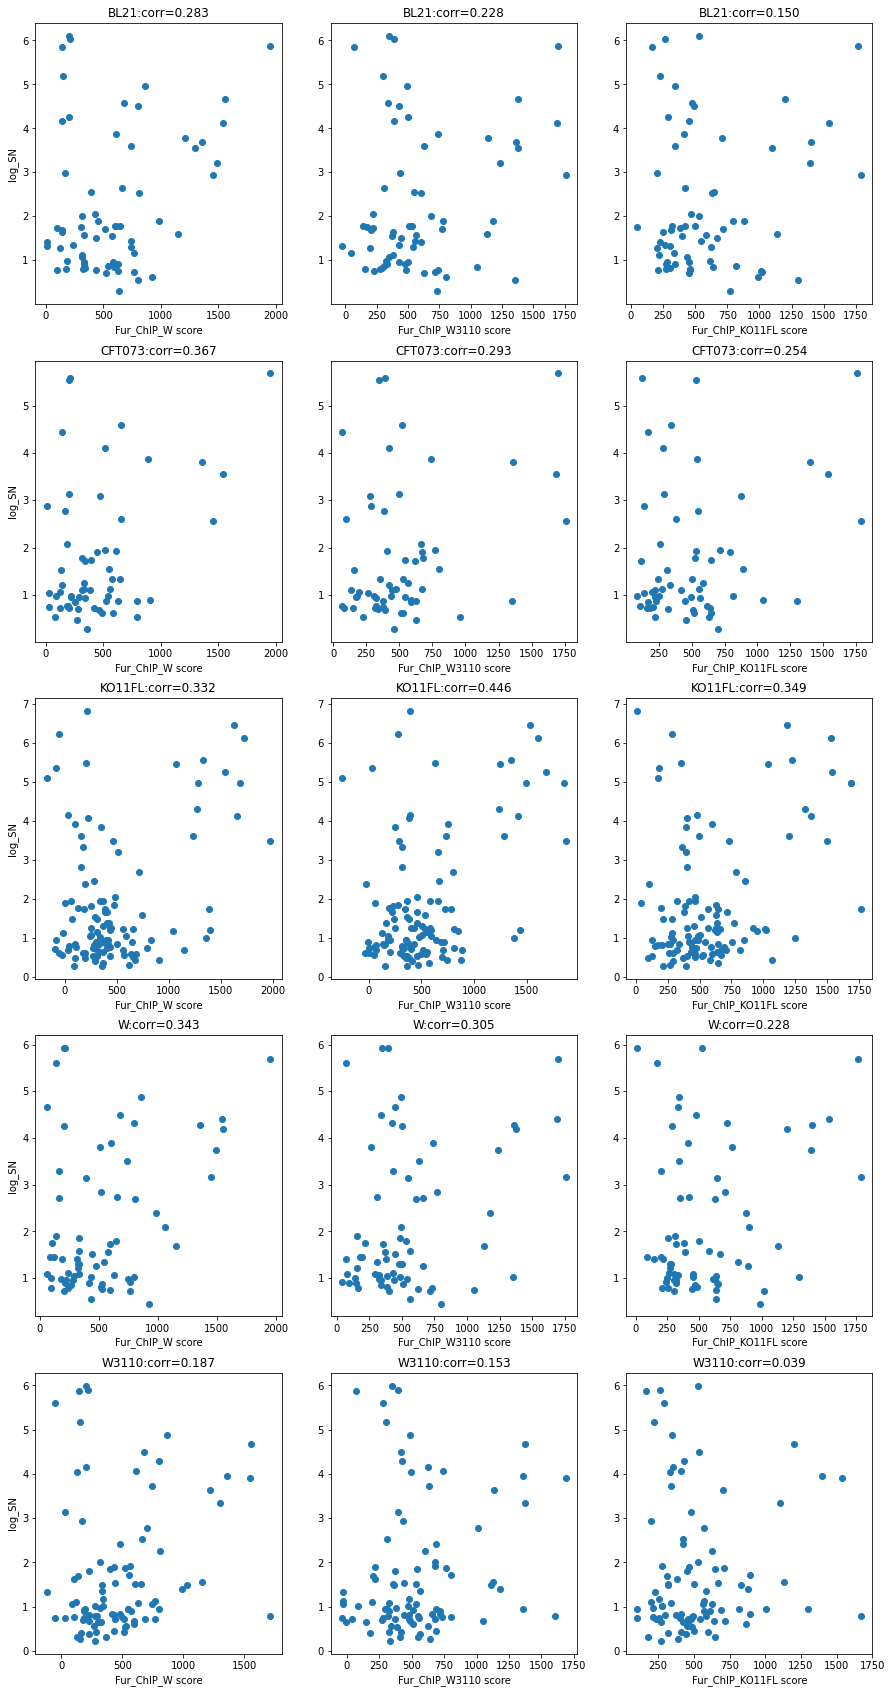

In [37]:
f_list = ['Fur_ChIP_W score','Fur_ChIP_W3110 score','Fur_ChIP_KO11FL score']
fig,axs = plt.subplots(5,3,figsize=(15,30))
for x in range(5):
    for y in range(len(f_list)):
        strain_name = labels[x+1]
        f_name = f_list[y]
        sn = list(merge_table_1[strain_name]['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(merge_table_1[strain_name][f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ':corr='+corr_txt)
        axs[x][y].set_xlabel( f_name)
        if y == 0:
            axs[x][y].set_ylabel('log_SN')

## site location comparison

In [67]:
dist_tss = {}
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
    dist_tss[strain_name] = []
    
    for i in range(len(merge_table_1[strain_name]['tss'])):
        tss = list(merge_table_1[strain_name]['tss'])[i]
        left = list(merge_table_1[strain_name]['ChIP-exo Start'])[i]
        right =  list(merge_table_1[strain_name]['ChIP-exo End'])[i]
        dist_tss[strain_name].append( (left+right)/2 - tss )

Text(0.5, 0.98, 'experimental chip site to tss distance')

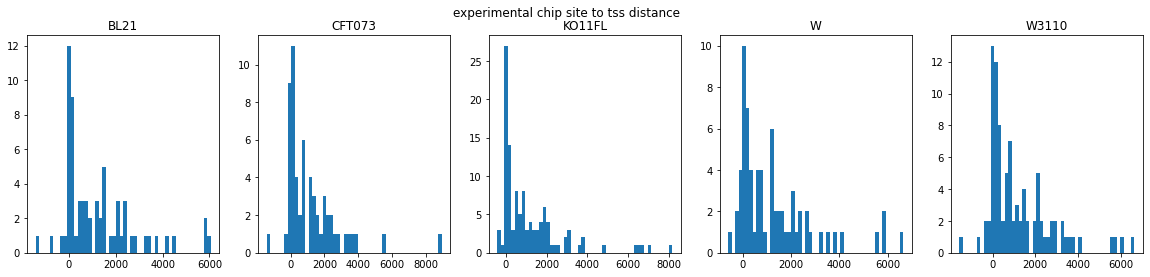

In [69]:
fig,axs = plt.subplots(1,5, figsize = (20,4))
for x in range(5):
    strain_name = labels[x+1]
    axs[x].hist( dist_tss[strain_name ], bins = 50)
    #axs[x].axvline(x=150,color='r')
    axs[x].set_title(strain_name)
fig.suptitle('experimental chip site to tss distance')

In [23]:
TFBS = pd.read_csv('../data/TFBS.csv')
fur_tfbs = TFBS[TFBS['TF name']=='Fur']
fur_tfbs = pd.concat( [ fur_tfbs.loc[ fur_tfbs['Evidence confidence level'] == 'Strong'], 
                   fur_tfbs.loc[ fur_tfbs['Evidence confidence level'] == 'Confirmed'] ])
fur_tfbs = fur_tfbs.reset_index()
fur_tfbs = fur_tfbs.drop(columns=['index'],axis=1)
fur_tfbs.head()

,TF name,TF-bs left end,TF-bs right end,strand,Evidence confidence level
0,Fur,167430,167448,forward,Strong
1,Fur,612650,612668,reverse,Strong
2,Fur,612650,612668,forward,Strong
3,Fur,612657,612675,reverse,Strong
4,Fur,612657,612675,forward,Strong


In [24]:
op_list = []
op_name_list = []
for i in range(len(fur_tfbs['TF-bs left end'])):
    left = list(fur_tfbs['TF-bs left end'])[i]
    right = list(fur_tfbs['TF-bs right end'])[i]
    temp_table = mg1655.features_in_range(left,right)
    if len(temp_table.index) < 1:
        op_list.append(None)
        op_name_list.append(None)
    else:
        temp_table = temp_table[ temp_table['type']=='operon']
        if len(temp_table.index) < 1:
            op_list.append(None)
            op_name_list.append(None)
        else:
            op_list.append( list(temp_table.index)[0] )
            op_name_list.append( list(temp_table['name'] )[0]  )
            
fur_tfbs['operon_id'] = op_list
fur_tfbs['operon_name'] = op_name_list
fur_tfbs = fur_tfbs.dropna()
fur_tfbs = fur_tfbs.reset_index()
fur_tfbs = fur_tfbs.drop(columns=['index'])      

In [25]:
tss_list = []
for i in range(len(fur_tfbs['TF-bs left end'])):
    op_id = list(fur_tfbs['operon_id'])[i]
    left,right = mg1655.operon_table.loc[op_id ]['left'], mg1655.operon_table.loc[op_id ]['right']
    temp_table = mg1655.features_in_range(left,right)
    temp_table = temp_table[ temp_table['type']=='tu']
    site = (list(fur_tfbs['TF-bs left end'])[i] + list(fur_tfbs['TF-bs right end'])[i])/2
    if len(temp_table['tss']) > 1:
        temp_tss_list = list(temp_table['tss'])
        temp_dist = []
        for tss in temp_tss_list:
            temp_dist.append( abs(tss-site) )
        min_index = temp_dist.index( min(temp_dist) )
        tss_list.append(temp_tss_list[min_index] )
    elif len(temp_table['tss']) < 1:
        tss_list.append( None )
    elif len(temp_table['tss']) == 1:
        tss_list.append(  list(temp_table['tss'])[0] )
        
fur_tfbs['tss'] = tss_list
fur_tfbs = fur_tfbs.dropna()
fur_tfbs = fur_tfbs.reset_index()
fur_tfbs = fur_tfbs.drop(columns=['index'])

(-200.0, 100.0)

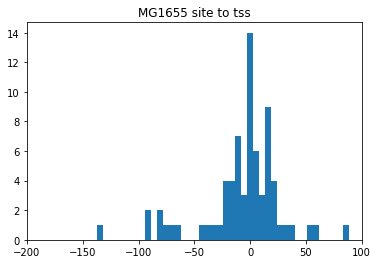

In [32]:
dist_tss = []
for i in range(len(fur_tfbs['TF-bs left end'])):
    site = (list(fur_tfbs['TF-bs left end'])[i] + list(fur_tfbs['TF-bs right end'])[i])/2
    tss =  list(fur_tfbs['tss'])[i]
    dist_tss.append( site - tss )
plt.hist( dist_tss,bins=300);
plt.title('MG1655 site to tss')
plt.xlim([-200,100])

## search around experimental chip site instead of tss

In [37]:
feature_table = {}
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
        
    feature = []
    bitome = bitomes_by_id[  name_to_id[strain_name] ]
    sn_table = Fur_multi_table[strain_name]
    
    for i in range(len(sn_table['ChIP-exo Start'])):
        data = {}
        data['tu_id'] = list(sn_table['tu_id'])[i]
        data['tu_name'] = list(sn_table['tu_name'])[i]
        left = list(sn_table['ChIP-exo Start'])[i]
        right =  list(sn_table['ChIP-exo End'])[i]
        site = (right+left)/2
        strand = bitome.tu_table.loc[data['tu_id']]['strand']
        data['tss'] = bitome.tu_table.loc[data['tu_id']]['tss']
        data['strand'] = strand
        for motif in fur_motifs.keys():
            #N_up = N_down = 40
            result = motif_match_noshape( site , strand , 40 ,40, bitome ,fur_motifs ,motif, False )
            data[motif+' score'] = result[motif+' score']
            
        feature.append( data )
    feature_table[ strain_name] = pd.DataFrame( feature )

merge_table_2 = {}
for strain_name in labels:
    if strain_name == 'mg1655':
        continue
    f_table = feature_table[strain_name]
    sn_table = Fur_multi_table[strain_name]
    rm_list = []
    for i in range(len(f_table['tu_id'])):
        if f_table['tu_id'][i] not in list(sn_table['tu_id']):
            rm_list.append(i)
    f_table= f_table.drop(rm_list)
    f_table = f_table.reset_index()
    f_table= f_table.drop(columns=['index'])
    sn_table = sn_table.merge(f_table, on='tu_id')
    merge_table_2[strain_name] = sn_table

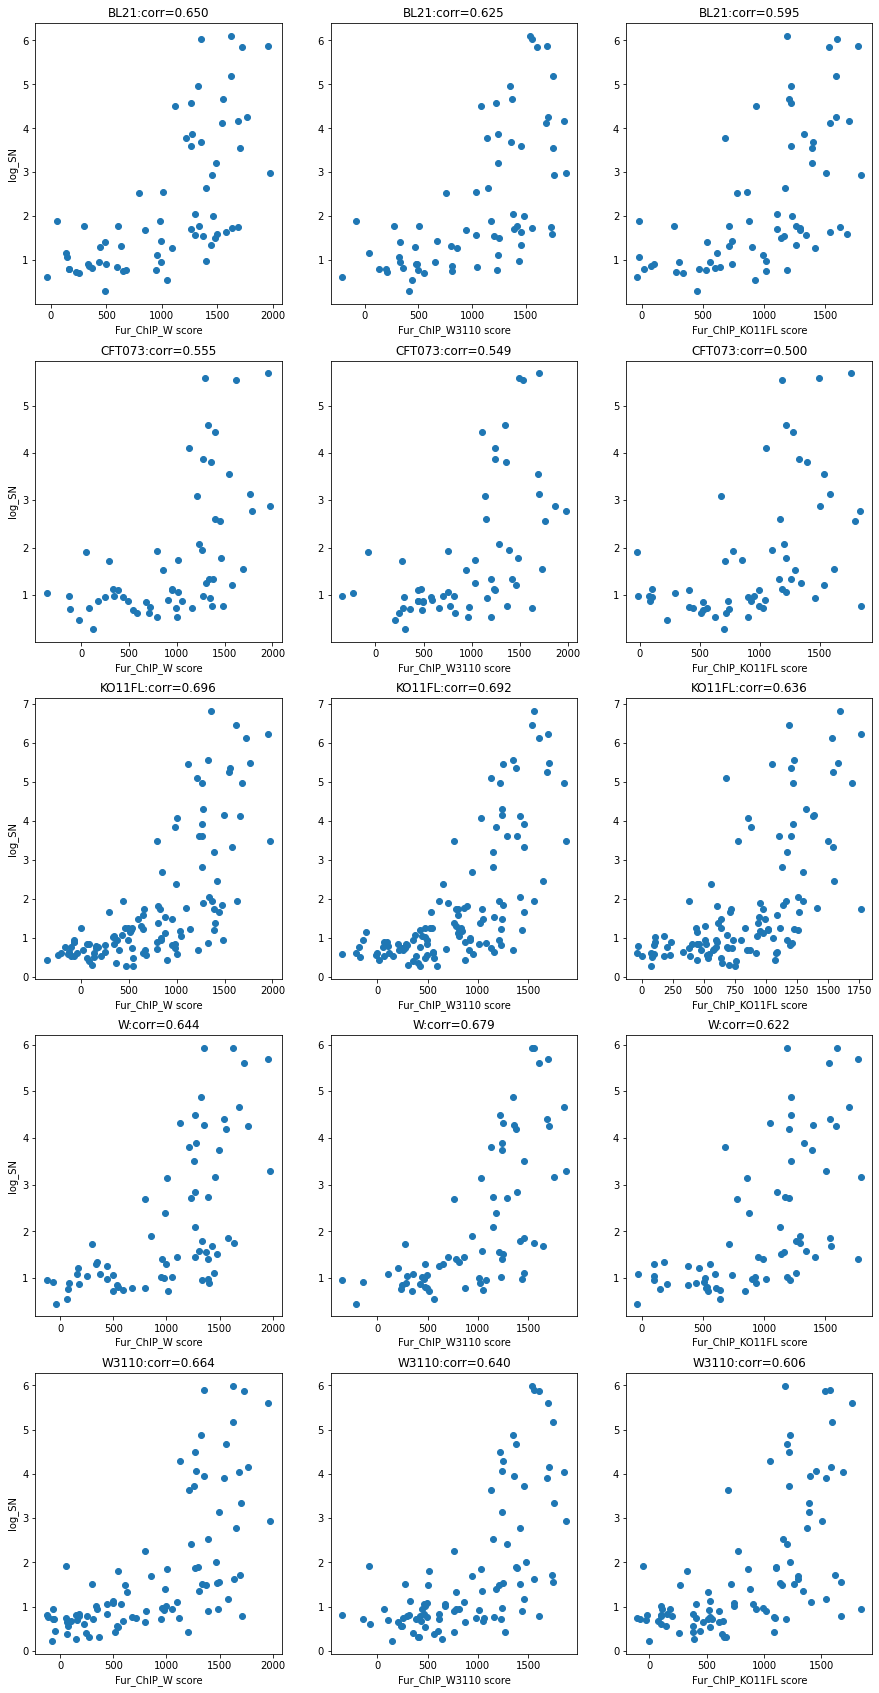

In [39]:
f_list = ['Fur_ChIP_W score','Fur_ChIP_W3110 score','Fur_ChIP_KO11FL score']
fig,axs = plt.subplots(5,3,figsize=(15,30))
for x in range(5):
    for y in range(len(f_list)):
        strain_name = labels[x+1]
        f_name = f_list[y]
        sn = list(merge_table_2[strain_name]['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(merge_table_2[strain_name][f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ':corr='+corr_txt)
        axs[x][y].set_xlabel( f_name)
        if y == 0:
            axs[x][y].set_ylabel('log_SN')

In [26]:
feature_table = {}
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
for strain_name in labels:
    feature = []
    if strain_name == 'mg1655':
        bitome = mg1655
        sn_table = mg1655_SN
        for i in range(len(sn_table['start'])):
            data = {}
            data['tu_id'] = list(sn_table['tu_id'])[i]
            data['tu_name'] = list(sn_table['TU'])[i]
            data['tss'] = bitome.tu_table.loc[data['tu_id']]['tss']
            tss = data['tss']
            if math.isnan(tss):
                continue
            strand = bitome.tu_table.loc[data['tu_id']]['strand']
            data['strand'] = strand
            #N_up =150, N_down = 30
            data_dir = '../data'
            data.update(motif_match_withshape( tss , strand , 150 ,30, bitome ,pwm_db ,'Fur', False, data_dir ) )
            data.update( motif_match_withshape( tss , strand , 150 ,30, 
                                                     bitome ,pwm_im ,'Fur-1', True, data_dir ) )
            data.update( motif_match_withshape( tss , strand , 150 ,30, 
                                                     bitome ,pwm_im,'Fur-2', True, data_dir ) )
            feature.append( data )
            
        feature_table[ strain_name] = pd.DataFrame( feature )
    else:
        
        bitome = bitomes_by_id[  name_to_id[strain_name] ]
        sn_table = Fur_multi_table[strain_name]
    
        for i in range(len(sn_table['ChIP-exo Start'])):
            data = {}
            data['tu_id'] = list(sn_table['tu_id'])[i]
            data['tu_name'] = list(sn_table['tu_name'])[i]
            left = list(sn_table['ChIP-exo Start'])[i]
            right =  list(sn_table['ChIP-exo End'])[i]
            site = (right+left)/2
            strand = bitome.tu_table.loc[data['tu_id']]['strand']
            data['tss'] = bitome.tu_table.loc[data['tu_id']]['tss']
            data['strand'] = strand
            #N_up = N_down = 40
            data_dir = '../data'
            data.update(motif_match_withshape( site , strand , 40 ,40, bitome ,pwm_db ,'Fur', False, data_dir ) )
            data.update( motif_match_withshape( site , strand , 40 ,40, 
                                                     bitome ,pwm_im ,'Fur-1', True, data_dir ) )
            data.update( motif_match_withshape( site , strand , 40 ,40, 
                                                     bitome ,pwm_im,'Fur-2', True, data_dir ) )
        
            feature.append( data )
        feature_table[ strain_name] = pd.DataFrame( feature )

merge_table_3 = {}
for strain_name in labels:
    if strain_name == 'mg1655':
        sn_table = mg1655_SN
    else:
        sn_table = Fur_multi_table[strain_name]
        
    f_table = feature_table[strain_name]
    rm_list = []
    for i in range(len(f_table['tu_id'])):
        if f_table['tu_id'][i] not in list(sn_table['tu_id']):
            rm_list.append(i)
    f_table= f_table.drop(rm_list)
    f_table = f_table.reset_index()
    f_table= f_table.drop(columns=['index'])
    sn_table = sn_table.merge(f_table, on='tu_id')
    merge_table_3[strain_name] = sn_table

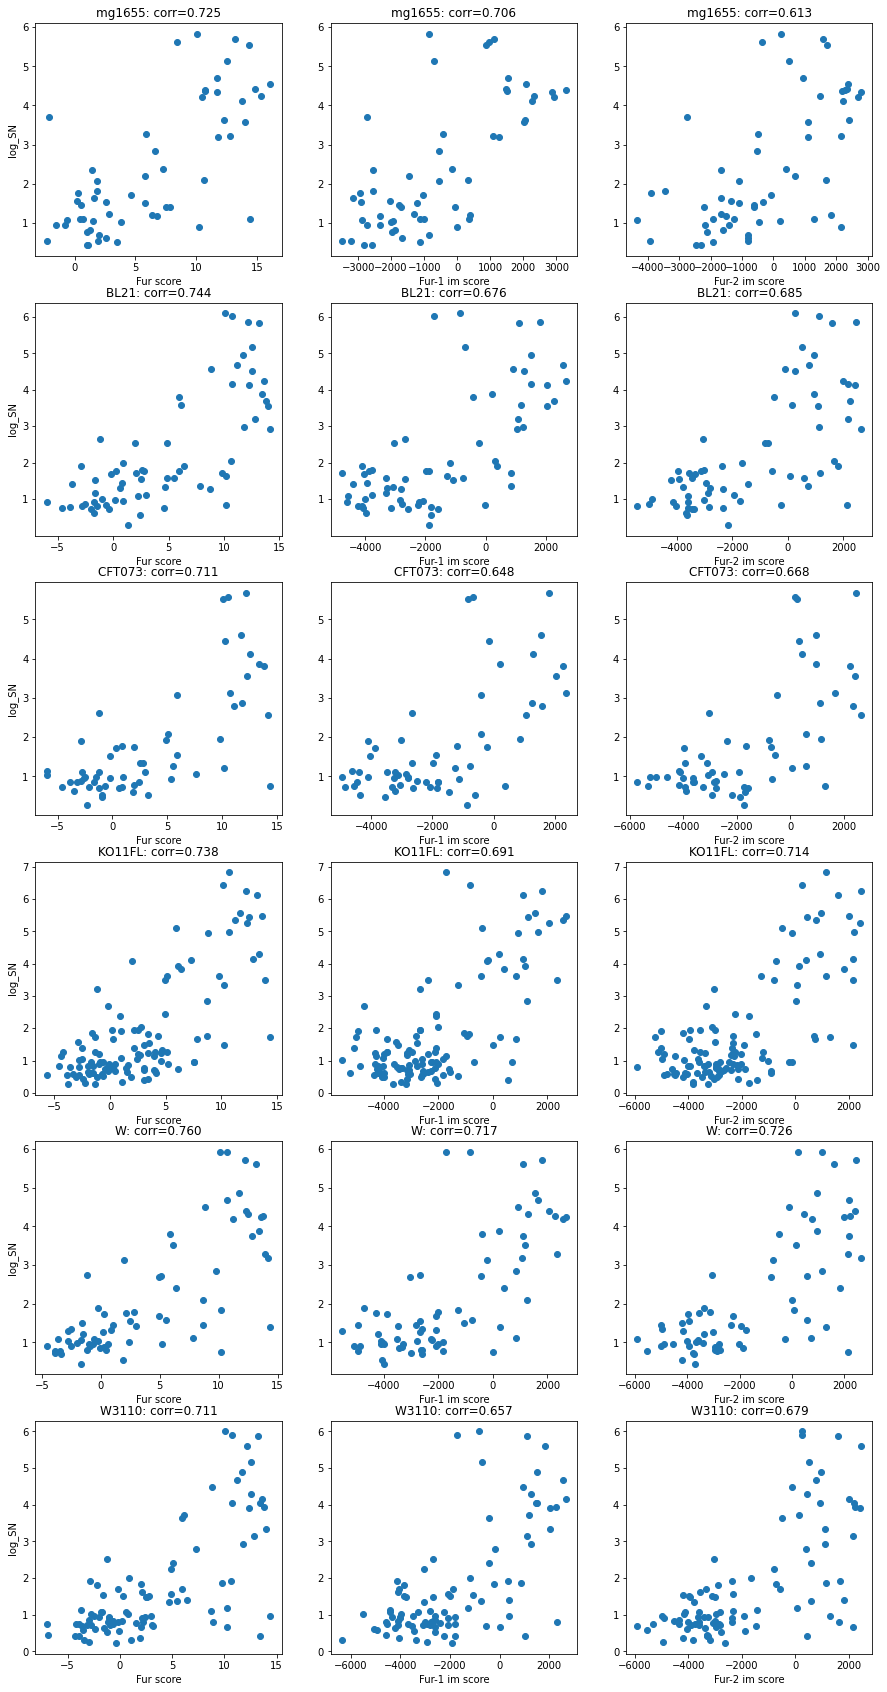

In [27]:
f_list = ['Fur score','Fur-1 im score','Fur-2 im score']
fig,axs = plt.subplots(6,3,figsize=(15,30))
for x in range(6):
    for y in range(len(f_list)):
        strain_name = labels[x]
        f_name = f_list[y]
        if strain_name == 'mg1655':
            sn =list(merge_table_3[strain_name]['SN_ratio'] )
        else:
            sn = list(merge_table_3[strain_name]['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(merge_table_3[strain_name][f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ': corr='+corr_txt)
        axs[x][y].set_xlabel( f_name )
        if y == 0:
            axs[x][y].set_ylabel('log_SN')

So it turns out that the range of binding box match is not appropriate for other strains

## Filter 

Filtered: site within (+/-200 to tss)


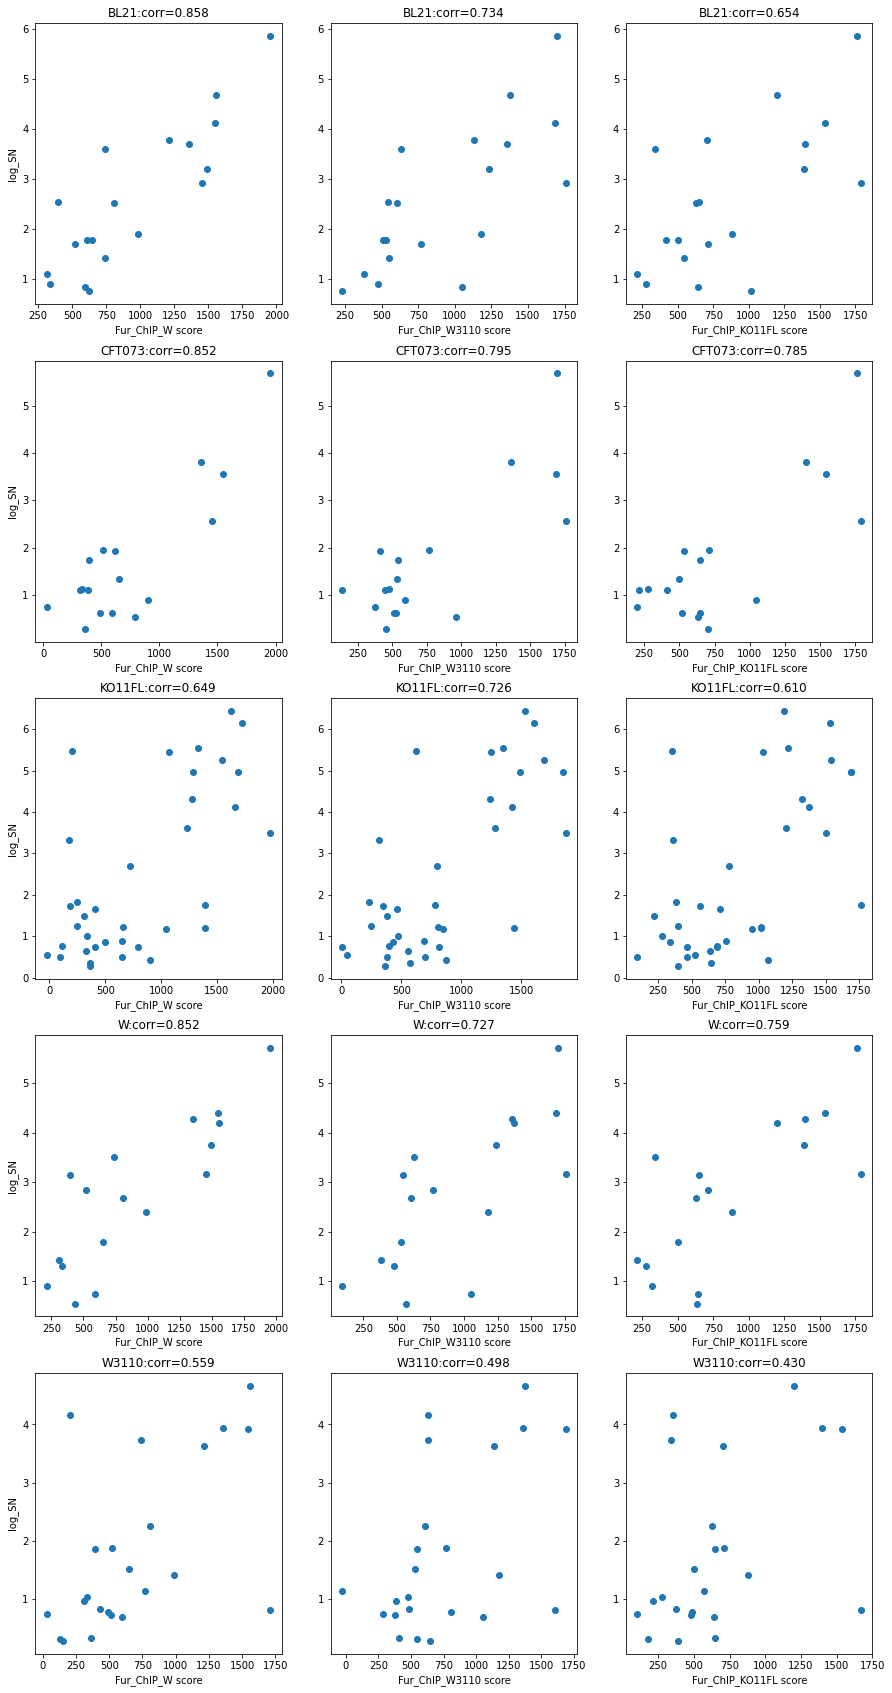

In [46]:
f_list = ['Fur_ChIP_W score','Fur_ChIP_W3110 score','Fur_ChIP_KO11FL score']
fig,axs = plt.subplots(5,3,figsize=(15,30))
for x in range(5):
    for y in range(len(f_list)):
        strain_name = labels[x+1]
        f_name = f_list[y]
        temp = merge_table_1[strain_name]
        temp = temp[ abs ((temp['ChIP-exo Start']+temp['ChIP-exo Start'])/2 - temp['tss']) < 200 ]
        
        sn = list(temp['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(temp[f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ':corr='+corr_txt)
        axs[x][y].set_xlabel( f_name)
        if y == 0:
            axs[x][y].set_ylabel('log_SN')
print("Filtered: site within (+/-200 to tss)")

Filtered: site within (+/-200 to tss)


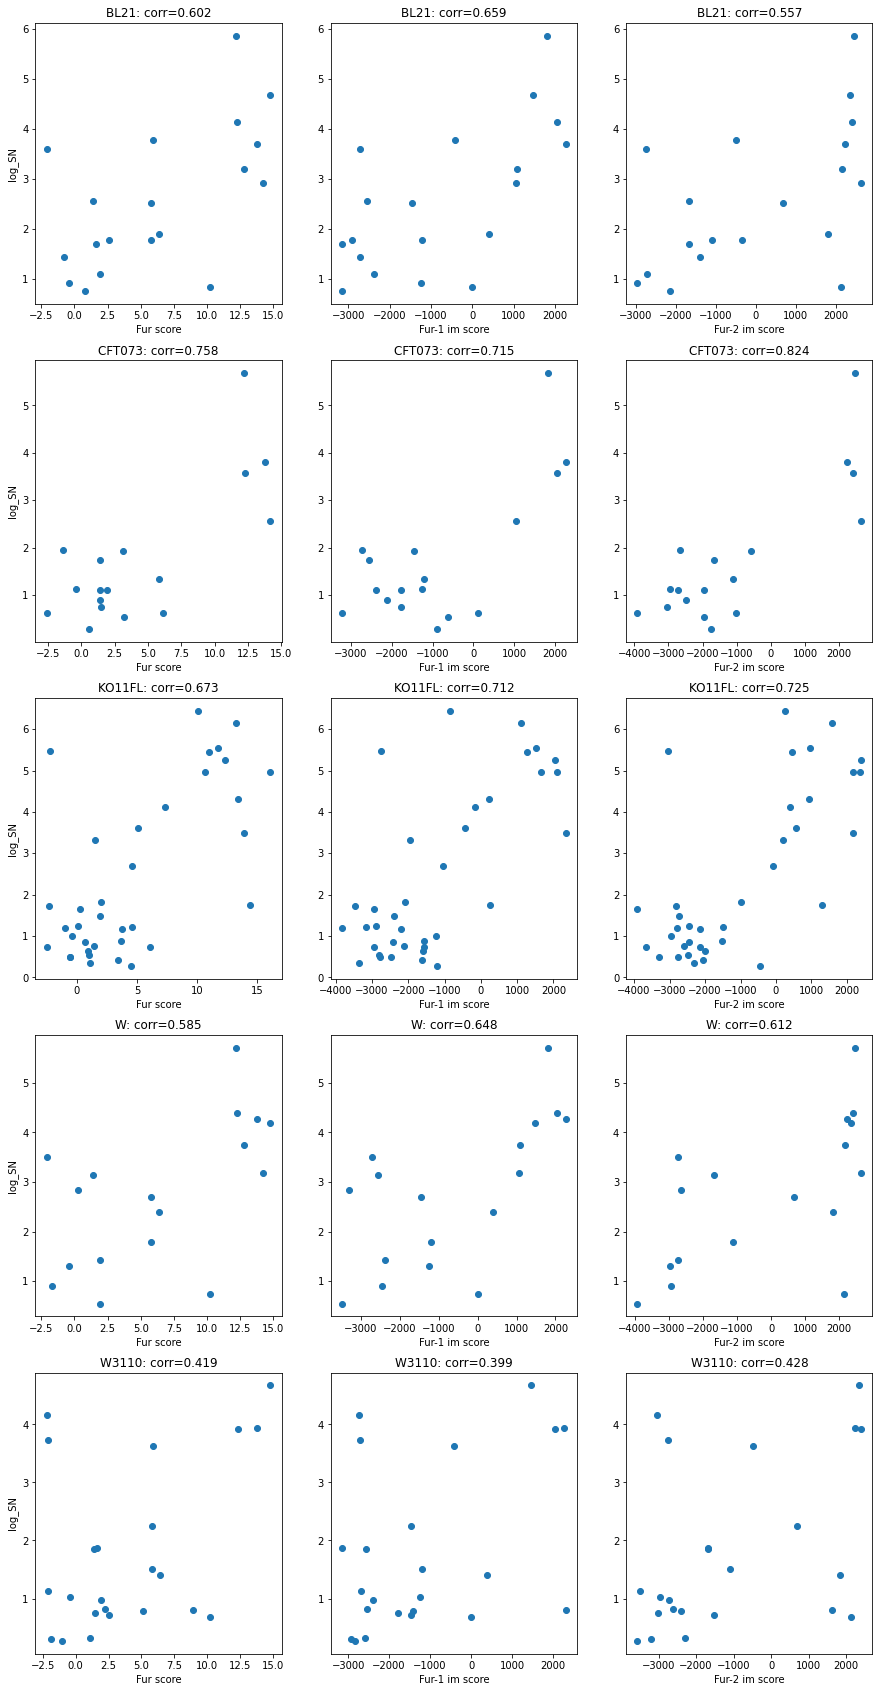

In [52]:
f_list = ['Fur score','Fur-1 im score','Fur-2 im score']
fig,axs = plt.subplots(5,3,figsize=(15,30))
for x in range(5):
    for y in range(len(f_list)):
        strain_name = labels[x+1]
        f_name = f_list[y]
        temp = merge_table[strain_name]
        temp = temp[ abs ((temp['ChIP-exo Start']+temp['ChIP-exo Start'])/2 - temp['tss']) < 200 ]
        
        sn = list(temp['S/N ratio'] )
        log_sn = [ log(v) for v in sn]
        score = list(temp[f_name])
        axs[x][y].scatter(score, log_sn)
        corr_txt = str(np.corrcoef( score , log_sn )[0,1])[0:5]
        axs[x][y].set_title( strain_name + ': corr='+corr_txt)
        axs[x][y].set_xlabel( f_name )
        if y == 0:
            axs[x][y].set_ylabel('log_SN')
print("Filtered: site within (+/-200 to tss)")

## regression model for SN ratios

In [26]:
columns_to_use = ['strand','Fur score','Fur HelT_avg', 'Fur HelT_range','Fur MGW_avg', 'Fur MGW_range', 
                  'Fur ProT_avg', 'Fur ProT_range',
       'Fur Roll_avg', 'Fur Roll_range', 'Fur HelT_max', 'Fur HelT_min',
       'Fur MGW_max', 'Fur MGW_min', 'Fur ProT_max', 'Fur ProT_min',
       'Fur Roll_max', 'Fur Roll_min',
       'Fur-1 im score',
       'Fur-1 im HelT_avg', 'Fur-1 im HelT_range', 'Fur-1 im MGW_avg',
       'Fur-1 im MGW_range', 'Fur-1 im ProT_avg', 'Fur-1 im ProT_range',
       'Fur-1 im Roll_avg', 'Fur-1 im Roll_range', 'Fur-1 im HelT_max',
       'Fur-1 im HelT_min', 'Fur-1 im MGW_max', 'Fur-1 im MGW_min',
       'Fur-1 im ProT_max', 'Fur-1 im ProT_min', 'Fur-1 im Roll_max',
       'Fur-1 im Roll_min', 
        'Fur-2 im score','Fur-2 im HelT_avg',
       'Fur-2 im HelT_range', 'Fur-2 im MGW_avg', 'Fur-2 im MGW_range',
       'Fur-2 im ProT_avg', 'Fur-2 im ProT_range', 'Fur-2 im Roll_avg',
       'Fur-2 im Roll_range', 'Fur-2 im HelT_max', 'Fur-2 im HelT_min',
       'Fur-2 im MGW_max', 'Fur-2 im MGW_min', 'Fur-2 im ProT_max',
       'Fur-2 im ProT_min', 'Fur-2 im Roll_max', 'Fur-2 im Roll_min']

In [28]:
X_to_try = {}
y_to_try = {}
for strain_name in merge_table_3.keys():
    temp = merge_table_3[strain_name][columns_to_use ]
    tempX = temp.iloc[:,:].values
    tempX = StandardScaler().fit_transform(tempX)
    X_to_try[strain_name] = tempX
    if strain_name == 'mg1655':
        sn_ratios = list(merge_table_3[strain_name]['SN_ratio'])   
    else:
        sn_ratios = list(merge_table_3[strain_name]['S/N ratio'])        
    y_to_try[strain_name] = sn_ratios

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [62]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(
        random_state=42,
        n_jobs=4
    )
}

In [63]:
result_df = pd.DataFrame(
    columns=['model', 'strain', 'train_r2', 'test_r2']
)

N_CV = 10

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_values in y_to_try.items():
        print(f'{model_name}: {y_name}')  
        
        cv_result = cross_validate(
            model,
            X_to_try[y_name],
            y= y_values,
            cv=N_CV,
            scoring='r2',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'strain': [y_name] * N_CV,
                'train_r2': cv_result['train_score'],
                'test_r2': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

ElasticNet
ElasticNet: mg1655


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


ElasticNet: BL21
ElasticNet: CFT073
ElasticNet: KO11FL
ElasticNet: W
ElasticNet: W3110
SVR
SVR: mg1655


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: BL21
SVR: CFT073
SVR: KO11FL
SVR: W
SVR: W3110


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF
RF: mg1655


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: BL21


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CFT073


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: KO11FL


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: W


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: W3110


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.4s finished


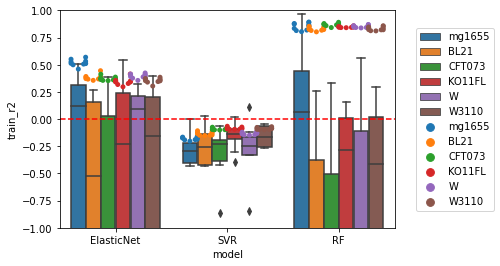

In [64]:
_, ax = plt.subplots()
sns.boxplot(x='model', y='test_r2', data=result_df, hue='strain', dodge=True, ax=ax)
sns.swarmplot(x='model', y='train_r2', data=result_df, hue='strain', dodge=True, ax=ax)
ax.set_ylim(-1,1)
plt.axhline(y=0,color ='r',ls='--')
ax.legend(loc="center left", bbox_to_anchor=(1.05,0.5))

In [65]:
hyperopt_models = {
    'ElasticNet': {
        'model':ElasticNet(),
        'param_dists': {
            'l1_ratio': np.arange(0,1,10),
             'alpha':np.logspace(0.1,10,10),
             'max_iter':np.array([1000,2500,4000])     
        }
    },
    'SVR': {
        'model': SVR(kernel='rbf',degree=3,epsilon=0.1),
        'param_dists': {
            'degree': [3,4,5,6,7,8,9,10],
            'gamma': ['scale', 'auto'],
            'C': np.arange(0.01, 10, 0.05),
        }
    },
    'RFR': {
        'model': RandomForestRegressor( verbose=1,random_state=42),
        'param_dists': {
            'n_estimators': np.arange(50, 250, 10),
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [66]:
hyperopt_EN = {}

for y_name, y_values in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['ElasticNet']['model'],
        hyperopt_models['ElasticNet']['param_dists'],
        n_iter=100,
        scoring='r2',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_to_try[y_name],y_values )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_EN[y_name] = hyperopt_results_df
    
dfs_with_SN = []
for y_name, hyperopt_df in hyperopt_EN.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_SN.append(hyperopt_df)
    
hyperopt_EN_df = pd.concat(dfs_with_SN, axis=0, ignore_index=True)

mg1655
Fitting 5 folds for each of 30 candidates, totalling 150 fits


The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.3s finished
Objective did not converge. You might want to increase the number of iterations. Duality gap: 167395.26945639687, tolerance: 33.990003395087726
The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


BL21
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.0s finished
Objective did not converge. You might want to increase the number of iterations. Duality gap: 275347.6821050649, tolerance: 59.94303686080992
The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CFT073
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.3s finished
Objective did not converge. You might want to increase the number of iterations. Duality gap: 82595.5133305293, tolerance: 21.448497137820254
The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KO11FL
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done 125 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.2s finished
Objective did not converge. You might want to increase the number of iterations. Duality gap: 721471.2476987657, tolerance: 186.4924752729963
The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


W
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.0s finished
Objective did not converge. You might want to increase the number of iterations. Duality gap: 197161.5810690764, tolerance: 42.70848014183694
The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


W3110
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.1s finished
Objective did not converge. You might want to increase the number of iterations. Duality gap: 237193.33239366068, tolerance: 51.31424855970217


(-1.0, 1.0)

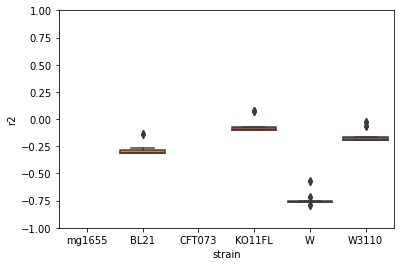

In [67]:
_, ax = plt.subplots()
sns.boxplot(x='strain', y='mean_test_score', data= hyperopt_EN_df,ax = ax )
ax.set_ylabel('r2')
ax.set_ylim(-1,1)

In [68]:
hyperopt_SVR = {}

for y_name, y_values in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['SVR']['model'],
        hyperopt_models['SVR']['param_dists'],
        n_iter=200,
        scoring='r2',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_to_try[y_name],y_values )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_SVR[y_name] = hyperopt_results_df
    
dfs_with_SN = []
for y_name, hyperopt_df in hyperopt_SVR.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_SN.append(hyperopt_df)
    
hyperopt_SVR_df = pd.concat(dfs_with_SN, axis=0, ignore_index=True)

mg1655
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


BL21
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CFT073
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KO11FL
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


W
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


W3110
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.0s finished


(-1.0, 1.0)

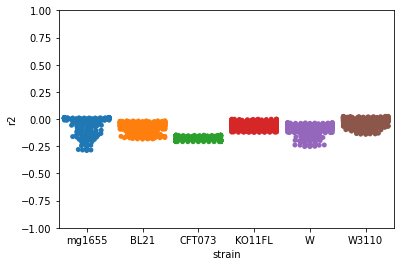

In [69]:
_, ax = plt.subplots()
sns.swarmplot(x='strain', y='mean_test_score', data= hyperopt_SVR_df,ax = ax )
ax.set_ylabel('r2')
ax.set_ylim(-1,1)

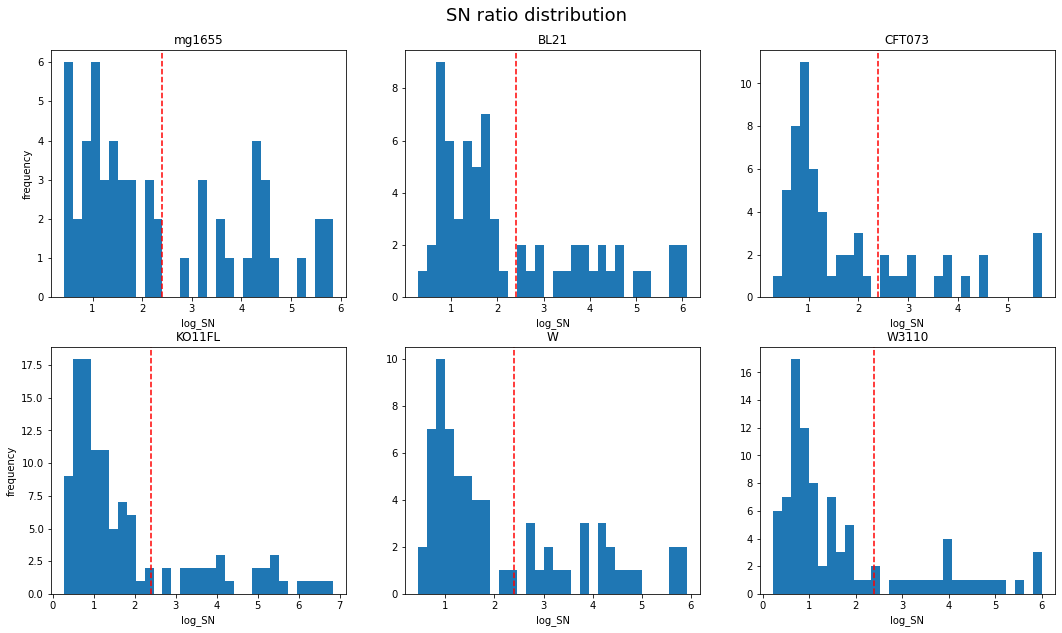

In [31]:
fig,axs = plt.subplots(2,3,figsize=(18,10))
for i in range(6):
    x_ax = int(i/3)
    y_ax = int(i%3)
    strain_name = list( merge_table_3.keys() )[i]
    if strain_name == 'mg1655':
        axs[x_ax][y_ax].hist(merge_table_3[strain_name]['log_SN'],bins=30)
    else:
        axs[x_ax][y_ax].hist( [ log(x) for x in merge_table_3[strain_name]['S/N ratio'] ],bins=30 )
    axs[x_ax][y_ax].axvline(x= 2.4,color = 'red',ls='--')
    axs[x_ax][y_ax].set_title(strain_name)
    axs[x_ax][y_ax].set_xlabel('log_SN')
    if y_ax == 0:
        axs[x_ax][y_ax].set_ylabel('frequency')
fig.suptitle('SN ratio distribution',y=0.94,fontsize= 18)
fig.savefig('../../../thesis_plots/SN_distribution.svg',dpi=150)

Text(0, 0.5, 'frequency')

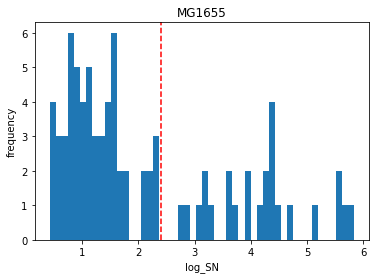

In [32]:
plt.hist(mg1655_SN['log_SN'],bins = 50)
plt.axvline(x= 2.4,color = 'red',ls='--')
plt.title('MG1655  SN ratio distribution')
plt.xlabel('log_SN')
plt.ylabel('frequency')

## set S/N = 10 as cutoff for high and low values

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

In [28]:
X_to_try = {}
y_to_try = {}
for strain_name in merge_table_3.keys():
    temp = merge_table_3[strain_name][columns_to_use ]
    tempX = temp.iloc[:,:].values
    tempX = StandardScaler().fit_transform(tempX)
    X_to_try[strain_name] = tempX
    
    if strain_name == 'mg1655':
        sn_ratios = list(merge_table_3[strain_name]['SN_ratio'])   
    else:
        sn_ratios = list(merge_table_3[strain_name]['S/N ratio'])   
        
    labels = [ int(sn > 10) for sn in sn_ratios ]
    y_to_try[strain_name] = labels

In [32]:
models_to_try = {
    'LR': LogisticRegression(),
    'SVM': LinearSVC()
}

In [39]:
result_df = pd.DataFrame(
    columns=['model', 'strain', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_to_try[y_name],
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'strain': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: mg1655


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: BL21
LR: CFT073
LR: KO11FL
LR: W


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: W3110
SVM
SVM: mg1655
SVM: BL21
SVM: CFT073
SVM: KO11FL
SVM: W
SVM: W3110


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


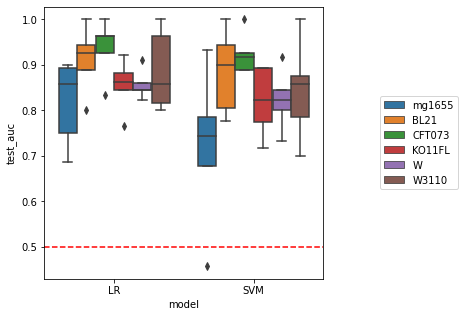

In [40]:
_, ax = plt.subplots(figsize=(5,5))
#sns.swarmplot(x='model', y='test_auc', data=result_df, hue='strain', dodge=True, ax=ax)
sns.boxplot(x='model', y='test_auc', data=result_df, hue='strain', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')

In [29]:
high = {}
low = {}
for strain_name in merge_table_3.keys():
    high[strain_name] = []
    low[strain_name] = []
    table = merge_table_3[ strain_name ]
    if strain_name == 'mg1655':
        for i in range(len(y_to_try[strain_name])):
            tu_name = list(table['TU'])[i]
            if y_to_try[strain_name][i] == 1:
                high[strain_name] = high[strain_name] + get_geneTU( tu_name )
            else:
                low[strain_name] = low[strain_name] + get_geneTU( tu_name )
    else:
        for i in range(len(y_to_try[strain_name])):
            op_id = list(table['operon_id'])[i]
            if y_to_try[strain_name][i] == 1:
                high[strain_name] = high[strain_name] + get_gene_byoperon(op_id )
            else:
                low[strain_name] = low[strain_name] + get_gene_byoperon(op_id )

In [30]:
from matplotlib_venn import venn2
from matplotlib_venn import venn3

In [36]:
fur_chip_reg = ['b2673', 'b2674', 'b2675', 'b2676', 'b2579', 'b0805', 'b2155', 'b2155', 'b0683', 'b0583', 'b0584', 'b0593', 'b0594', 'b0595', 'b0596', 'b0597', 'b0683', 'b3005', 'b3006', 'b3005', 'b1102', 'b0755', 'b4451', 'b2671', 'b0588', 'b0589', 'b0590', 'b3938', 'b0150', 'b0151', 'b0152', 'b0153', 'b3441', 'b1546', 'b1547', 'b1548', 'b4567', 'b1679', 'b1680', 'b1681', 'b1682', 'b1683', 'b1684', 'b1334', 'b0428', 'b0429', 'b0430', 'b0431', 'b0432', 'b0721', 'b0722', 'b0723', 'b0724', 'b0726', 'b0727', 'b0728', 'b0729', 'b1611', 'b1891', 'b1892', 'b4292', 'b4293', 'b1109', 'b4122', 'b0592', 'b3212', 'b3213', 'b3214', 'b1852', 'b4062', 'b1243', 'b1244', 'b1245', 'b1246', 'b1247', 'b0116', 'b0585', 'b4511', 'b0586', 'b0587', 'b0928', 'b0167', 'b1732', 'b1761', 'b2029', 'b2552', 'b2741', 'b4287', 'b4288', 'b4289', 'b4290', 'b4291', 'b4063', 'b3123', 'b3124', 'b3125', 'b3126', 'b3127', 'b1988', 'b0450', 'b0451', 'b3942', 'b4019', 'b0929', 'b1658', 'b1062', 'b3908', 'b4367', 'b2392', 'b1973', 'b3408', 'b3409', 'b3410', 'b3324', 'b3325', 'b3326', 'b3327', 'b3328', 'b3329', 'b3330', 'b3331', 'b3332', 'b3333', 'b3334', 'b3335', 'b2106', 'b2107', 'b3070', 'b1821']

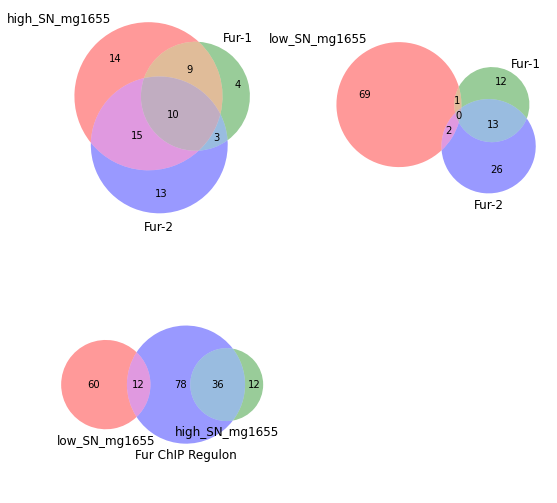

In [43]:
fig,axs = plt.subplots(2,2,figsize=(9,9))
venn3([set(high['mg1655']),set(IM_genes['Fur-1']),set(IM_genes['Fur-2']) ],set_labels=['high_SN_mg1655', 'Fur-1','Fur-2'], 
          ax = axs[0][0])
venn3([set(low['mg1655']),set(IM_genes['Fur-1']),set(IM_genes['Fur-2']) ],set_labels=['low_SN_mg1655', 'Fur-1','Fur-2'], 
          ax = axs[0][1])
venn3([set(low['mg1655']),set(high['mg1655']),set(fur_chip_reg) ],
      set_labels=['low_SN_mg1655', 'high_SN_mg1655','Fur ChIP Regulon'],ax = axs[1][0])
axs[-1][-1].axis('off')
fig.savefig('../../../thesis_plots/SN_regulon_venn.svg',dpi=150)

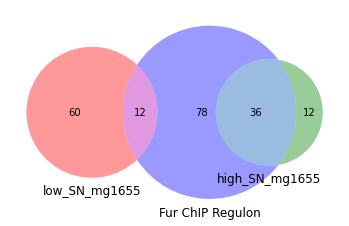

In [44]:
venn3([set(low['mg1655']),set(high['mg1655']),set(fur_chip_reg) ],set_labels=['low_SN_mg1655', 'high_SN_mg1655','Fur ChIP Regulon'])

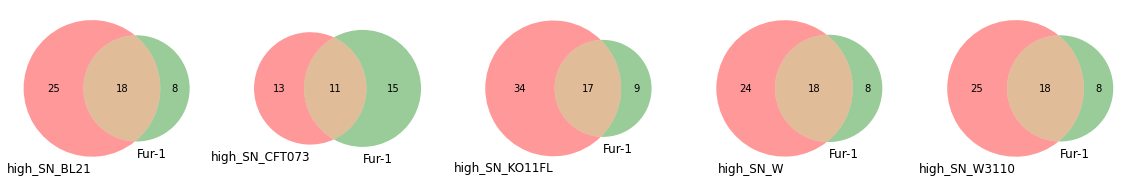

In [34]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    strain_name = list( merge_table_3.keys() )[i+1]
    venn2([set(high[strain_name]),set(IM_genes['Fur-1'])],set_labels=['high_SN_'+strain_name, 'Fur-1'], 
          ax = axs[i])

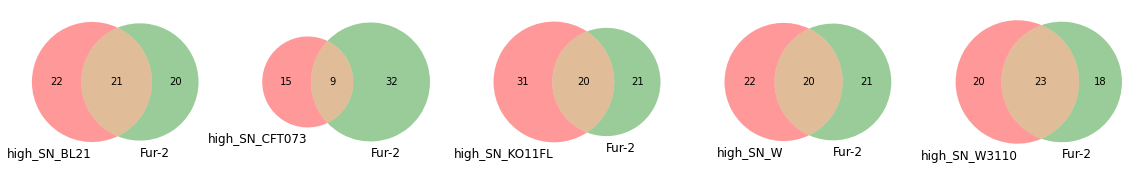

In [35]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    strain_name = list( merge_table_3.keys() )[i+1]
    venn2([set(high[strain_name]),set(IM_genes['Fur-2'])],set_labels=['high_SN_'+strain_name, 'Fur-2'], 
          ax = axs[i] )

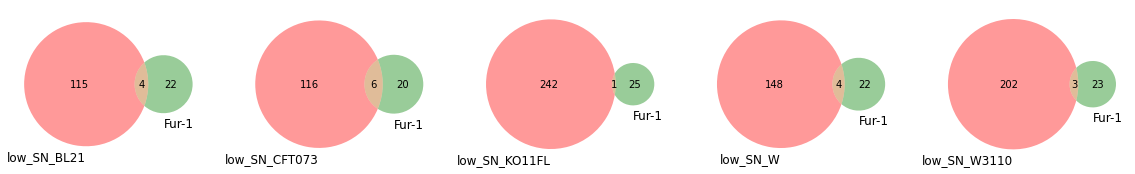

In [86]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    strain_name = list( merge_table_3.keys() )[i+1]
    venn2([set(low[strain_name]),set(IM_genes['Fur-1'])],set_labels=['low_SN_'+strain_name, 'Fur-1'], ax = axs[i])

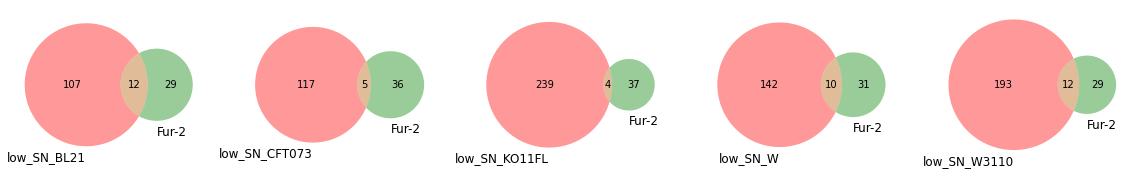

In [87]:
fig,axs = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    strain_name = list( merge_table_3.keys() )[i+1]
    venn2([set(low[strain_name]),set(IM_genes['Fur-2'])],set_labels=['low_SN_'+strain_name, 'Fur-2'], ax = axs[i])

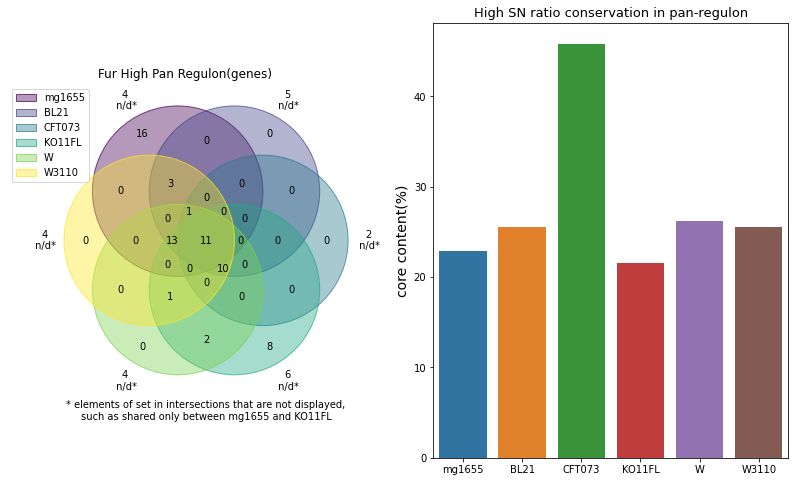

In [44]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']

from venn import pseudovenn
sets = {}
conservation = []
for strain_name in labels:
    sets[strain_name] = set( high[strain_name] )
    conservation.append( 11*100/len(set( high[strain_name] ))   )
    
fig, axs = plt.subplots(1,2, figsize=(14,8))
pseudovenn(sets, ax=axs[0],legend_loc="upper left",fontsize = 9.9)
axs[0].set_title('Fur High Pan Regulon(genes)')
#axs[0].legend(loc='upper left')

sns.barplot(x=labels,y=conservation,ax=axs[1])
axs[1].set_ylabel('core content(%)',fontsize = 14)
axs[1].set_title('High SN ratio conservation in pan-regulon',fontsize=13)
fig.savefig("../../../thesis_plots/high_panregulon.svg",dpi=150)

### hyper param optimization

In [31]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-1,2,15),
            'max_iter':np.array([100,200,500,1000,1500,2000])
        }
    }
}

In [32]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter= 100,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(  X_to_try[y_name] ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df
    
# combine all the hyperopt results into a DF
dfs_with_strains = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['strain'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_strains.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_strains, axis=0, ignore_index=True)

mg1655
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


BL21
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CFT073
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KO11FL
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 283 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


W
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


W3110
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 493 out of 500 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.3s finished


(0.5, 1.0)

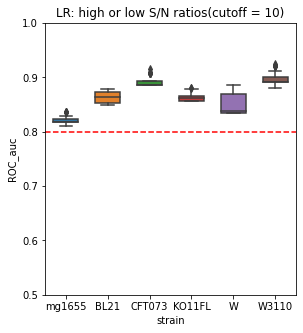

In [34]:
plt.figure(figsize=(4.5,5) )
#sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='strain', y='mean_test_score', data=hyperopt_LR_df, width=0.6)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('ROC_auc')
plt.title('LR: high or low S/N ratios(cutoff = 10)')
plt.ylim([0.5,1])

In [33]:
import shap
from sklearn.model_selection import train_test_split

In [68]:
y_to_try.keys()

dict_keys(['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110'])

In [69]:
shap_vals= {}
for strain_name in y_to_try.keys():
    sub_table = hyperopt_LR_df[ hyperopt_LR_df['strain']==strain_name]
    sub_table = sub_table.sort_values(by='mean_test_score', ascending=False)
    params = list(sub_table['params'])[0]
    clf = LogisticRegression()
    clf.set_params( penalty = params['penalty'])
    clf.set_params( C = params['C'])
    clf.set_params( max_iter = params['max_iter'])
    
    X_fi = pd.DataFrame( X_to_try[strain_name], columns= columns_to_use , index=merge_table_3[strain_name].index)
    y = pd.Series( y_to_try[strain_name] )
    X_train, X_test, y_train, y_test = train_test_split( X_fi, y, test_size=0.3, random_state=7)
    clf.fit(X_train, y_train)
    explainer = shap.Explainer(clf, X_train )
    shap_vals[strain_name] = explainer(X_test)

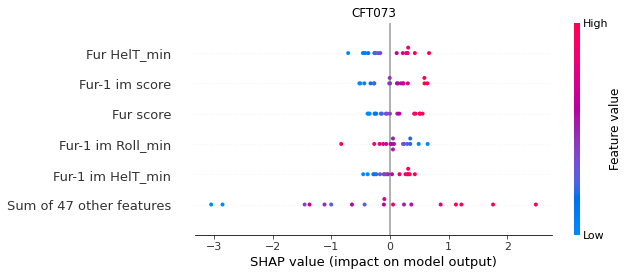

In [70]:
plt.title('CFT073')
shap.plots.beeswarm(shap_vals['CFT073'],max_display=6)

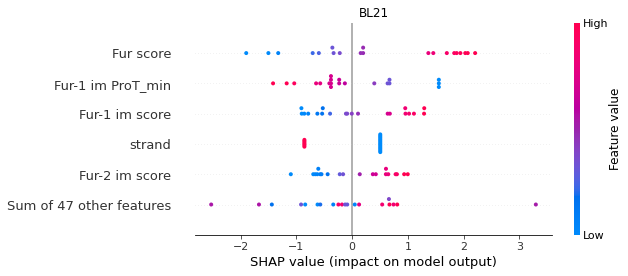

In [71]:
plt.title('BL21')
shap.plots.beeswarm(shap_vals['BL21'],max_display=6)

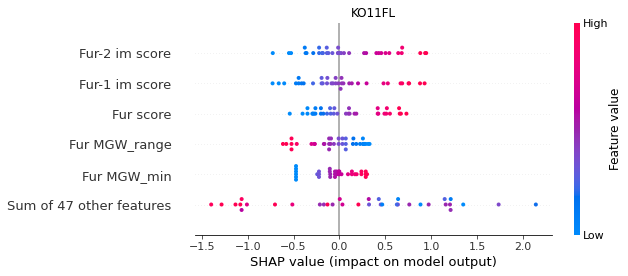

In [72]:
plt.title('KO11FL')
shap.plots.beeswarm(shap_vals['KO11FL'],max_display=6)

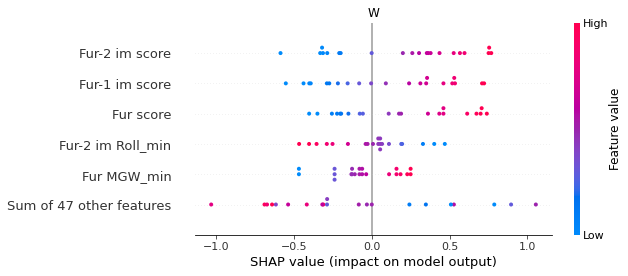

In [73]:
plt.title('W')
shap.plots.beeswarm(shap_vals['W'],max_display=6)

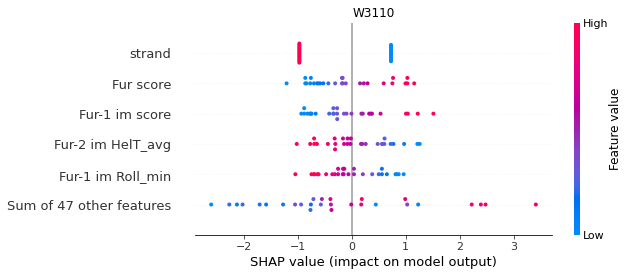

In [74]:
plt.title('W3110')
shap.plots.beeswarm(shap_vals['W3110'],max_display=6)

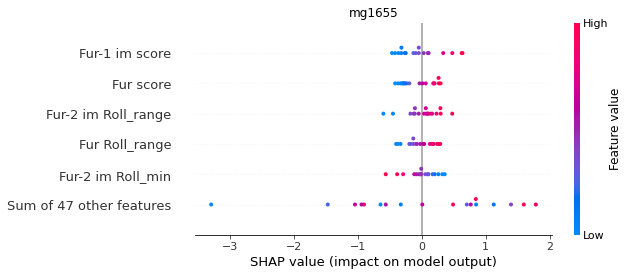

In [75]:
plt.title('mg1655')
shap.plots.beeswarm(shap_vals['mg1655'],max_display=6)

## LR_clf:  mg1655 as fixed train set, other 5 strains as test set.

In [33]:
from sklearn.metrics import roc_auc_score
LR_params = {'penalty': ['l1', 'l2'],
            'C': np.logspace(-1,2,15) }
X_test = {}
y_test = {}
temp_ind = 0
ind_strain = {}
for strain_name in merge_table_3.keys():
    temp = merge_table_3[strain_name][columns_to_use ]
    tempX = temp.iloc[:,:].values
    ind_strain[strain_name] = ( temp_ind,temp_ind+len(tempX) )
    temp_ind = temp_ind+len(tempX)
    if strain_name == 'mg1655':
        X_tot = tempX
    else:
        X_tot = np.concatenate((X_tot, tempX), axis=0)
        
    if strain_name != 'mg1655':
        sn_ratios = list(merge_table_3[strain_name]['S/N ratio'])
        labels = [ int(sn > 10) for sn in sn_ratios ]
        y_test[strain_name] = labels
        
        
X_tot = StandardScaler().fit_transform( X_tot )
for strain_name in merge_table_3.keys():
    if strain_name != 'mg1655':
        X_test[strain_name] = X_tot[ ind_strain[strain_name][0]:ind_strain[strain_name][1] ]
    else:
        X_train = X_tot[ ind_strain[strain_name][0]:ind_strain[strain_name][1] ]
        sn_ratios = list(merge_table_3[strain_name]['SN_ratio'])
        y_train = [ int(sn > 10) for sn in sn_ratios ]

In [34]:
opt_LR_raw = []
for strain_name in ['BL21', 'CFT073', 'KO11FL', 'W', 'W3110']:
    for p in LR_params['penalty']:
        for C_param in LR_params['C']:
            data = {'strain': strain_name}
            data['penalty'] = p
            data['C'] = C_param
            clf = LogisticRegression(solver = 'liblinear',max_iter = 2000)
            clf.set_params( penalty = p)
            clf.set_params(C = C_param)
            clf.fit(X_train,y_train)
            result = roc_auc_score( y_test[strain_name], clf.predict_proba( X_test[strain_name] )[:, 1])
            data['roc_auc'] = result
            opt_LR_raw.append(data)
opt_LR = pd.DataFrame(opt_LR_raw)
opt_LR.head()

,strain,penalty,C,roc_auc
0,BL21,l1,0.100000,0.853387
1,BL21,l1,0.163789,0.863498
2,BL21,l1,0.268270,0.908999
3,BL21,l1,0.439397,0.920121
4,BL21,l1,0.719686,0.944388


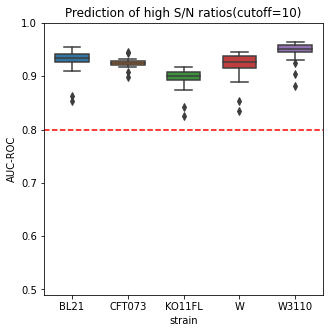

In [35]:
plt.figure(figsize=(5,5))
sns.boxplot(x='strain', y='roc_auc', data=opt_LR,width=0.6)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.ylabel('AUC-ROC')
plt.title('Prediction of high S/N ratios(cutoff=10)')
plt.ylim([0.49,1])
plt.savefig('../../../thesis_plots/LR_predict_furSN.svg',dpi=150)

Text(0.5, 1.01, 'LR: predict high S/N ratios(cutoff = 10)')

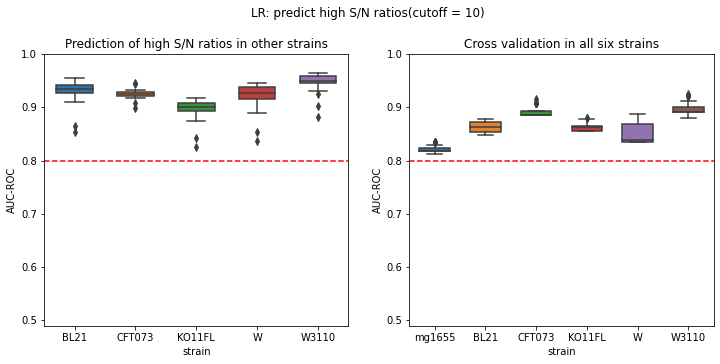

In [41]:
fig,axs = plt.subplots(1,2,figsize=(12,5))
sns.boxplot(x='strain', y='roc_auc', data=opt_LR,width=0.6, ax = axs[0])
axs[0].axhline(y= 0.8, color = 'r', ls = '--')
axs[0].set_ylabel('AUC-ROC')
axs[0].set_title('Prediction of high S/N ratios in other strains')
axs[0].set_ylim([0.49,1])

sns.boxplot(x='strain', y='mean_test_score', data=hyperopt_LR_df, width=0.6,ax = axs[1])
axs[1].axhline(y= 0.8, color = 'r', ls = '--')
axs[1].set_ylabel('AUC-ROC')
axs[1].set_title('Cross validation in all six strains')
axs[1].set_ylim([0.49,1])
fig.suptitle('LR: predict high S/N ratios(cutoff = 10)',y=1.01)

In [36]:
import shap
X_train_matrix = pd.DataFrame( X_train, columns= columns_to_use, index=merge_table_3['mg1655'].index)
y_train_label = pd.Series(  y_train )
shap_vals= {}
for strain_name in ['BL21', 'CFT073', 'KO11FL', 'W', 'W3110']:
    sub_table = opt_LR[ opt_LR['strain']==strain_name]
    sub_table = sub_table.sort_values(by='roc_auc', ascending=False)
    clf = LogisticRegression(solver = 'liblinear',max_iter = 2000)
    clf.set_params( penalty = list(sub_table['penalty'])[0] )
    clf.set_params( C =list(sub_table['C'])[0]  )
    
    
    X_test_matrix = pd.DataFrame( X_test[strain_name], columns= columns_to_use , index=merge_table_3[strain_name].index)
    y_test_label = pd.Series( y_test[strain_name] )
    
    clf.fit(X_train_matrix, y_train_label)
    explainer = shap.Explainer(clf, X_train_matrix )
    shap_vals[strain_name] = explainer(X_test_matrix)

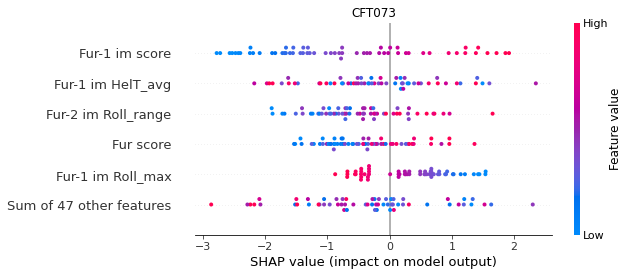

In [43]:
shap.plots.beeswarm(shap_vals['CFT073'],max_display=6,show=False)
plt.title('CFT073')
plt.savefig('../../../thesis_plots/CFT073_predSN_features.svg',dpi=150)

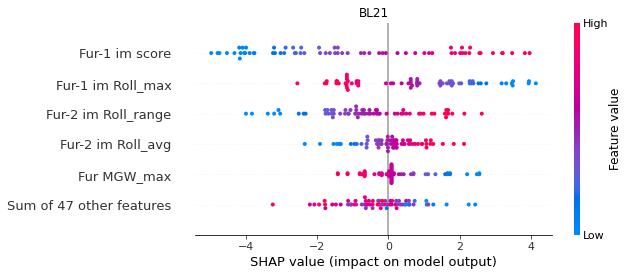

In [44]:
plt.title('BL21')
shap.plots.beeswarm(shap_vals['BL21'],max_display=6,show=False)
plt.savefig('../../../thesis_plots/BL21_predSN_features.svg',dpi=150)

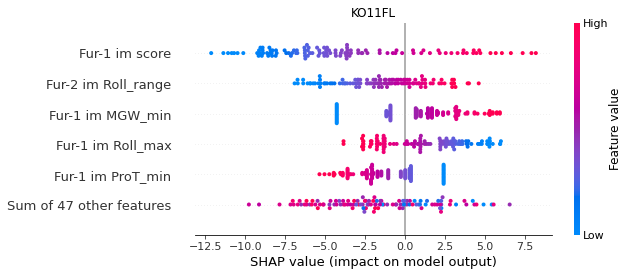

In [45]:
plt.title('KO11FL')
shap.plots.beeswarm(shap_vals['KO11FL'],max_display=6,show=False)
plt.savefig('../../../thesis_plots/KO11FL_predSN_features.svg',dpi=150)

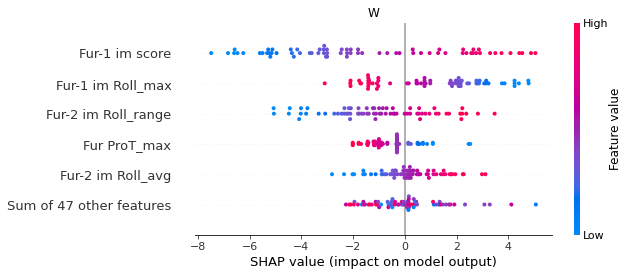

In [46]:
plt.title('W')
shap.plots.beeswarm(shap_vals['W'],max_display=6,show=False)
plt.savefig('../../../thesis_plots/W_predSN_features.svg',dpi=150)

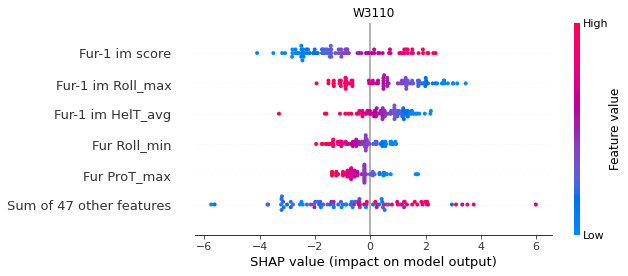

In [47]:
plt.title('W3110')
shap.plots.beeswarm(shap_vals['W3110'],max_display=6,show=False)
plt.savefig('../../../thesis_plots/W3110_predSN_features.svg',dpi=150)

In [89]:
from scipy.stats import ttest_ind
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
pvalues = {}
for strainname in labels:
    roll = {1:[],0:[] }
    for i in range(len(  merge_table_3[strainname]['Fur-1 im Roll_range'] )):
        roll[ y_to_try[strainname][i]].append( merge_table_3[strainname]['Fur-1 im Roll_range'][i] )
    
    
    pvalues[strainname]= ttest_ind( list(roll[1]),list(roll[0]) ).pvalue
print(pvalues)

{'mg1655': 0.5707687863935131, 'BL21': 0.008202971401429003, 'CFT073': 2.651588462517437e-05, 'KO11FL': 0.04642421075630956, 'W': 0.00038202368501708044, 'W3110': 7.039079006100168e-05}


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

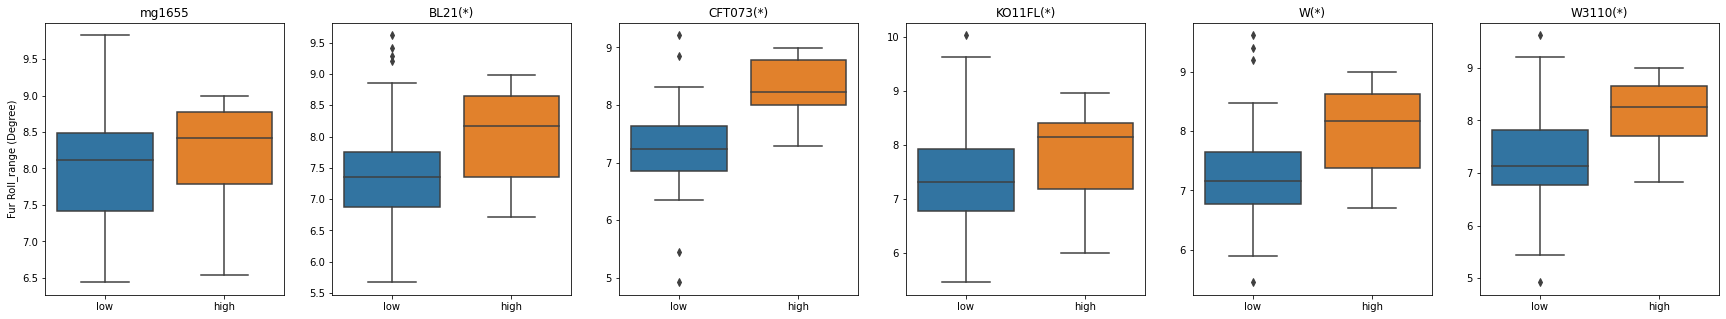

In [31]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
fig,axs = plt.subplots(1,6,figsize=(30,5))
for i in range(len(labels)):
    strain_name = labels[i]
    sns.boxplot( y_to_try[strain_name], merge_table_3[strain_name]['Fur-1 im Roll_range'], ax = axs[i])
    if strain_name !='mg1655':
        axs[i].set_title(strain_name+'(*)')
    else:
        axs[i].set_title(strain_name )
        
    axs[i].set_xticklabels(['low','high'])
    axs[i].set_ylabel('')
axs[0].set_ylabel('Fur Roll_range (Degree)')
fig.savefig('../../../thesis_plots/fur_roll.svg',dpi=150)

## unique genes in strain's regulons

In [92]:
from scipy.stats import f_oneway
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
pvalues = {}
for strainname in labels:
    score = {'core':[],'accessory':[],'unique':[]}
    for i in range(len( merge_table_3[strainname]['regulon_region'] )):
        score[ merge_table_3[strainname]['regulon_region'][i]].append( merge_table_3[strainname]['Fur score'][i] )
    
    pvalues[strainname]=f_oneway(score['core'],score['accessory'],score['unique']).pvalue
print(pvalues)

{'mg1655': 0.2886210499894421, 'BL21': 0.32399576165727956, 'CFT073': 0.024847779049518046, 'KO11FL': 0.00025458059987387564, 'W': 0.04409978874786742, 'W3110': 0.0005675521696710341}


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

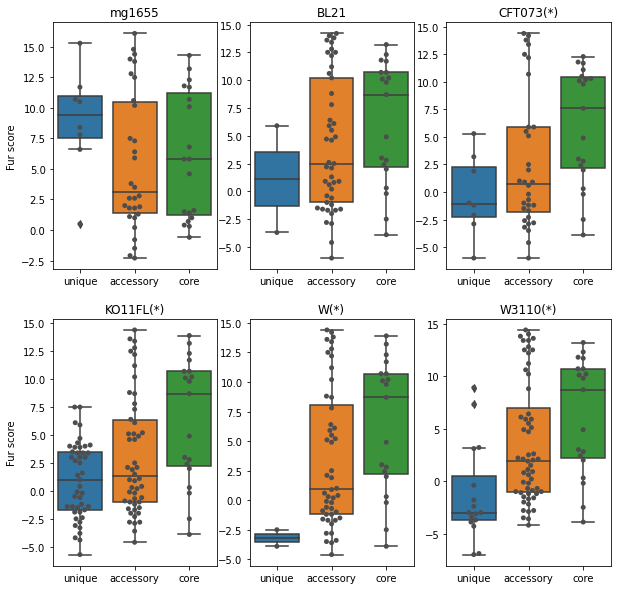

In [94]:
labels =['mg1655', 'BL21', 'CFT073', 'KO11FL', 'W', 'W3110']
fig,axs = plt.subplots(2,3,figsize=(10,10))
for i in range(len(labels)):
    x_axis = int(i/3)
    y_axis = int(i%3)
    strain_name = labels[i]
    regulon_region = merge_table_3[strain_name]['regulon_region']
    sns.boxplot(regulon_region,merge_table_3[strain_name]['Fur score'],ax=axs[x_axis][y_axis], 
                order=["unique", "accessory","core"])
    sns.swarmplot(regulon_region,merge_table_3[strain_name]['Fur score'],ax=axs[x_axis][y_axis], 
                order=["unique", "accessory","core"], color = ".3")
    if strain_name in ['mg1655','BL21']:    
        axs[x_axis][y_axis].set_title( strain_name )
    else:
        axs[x_axis][y_axis].set_title( strain_name+'(*)' )
    axs[x_axis][y_axis].set_xlabel('')
    if y_axis != 0:
        axs[x_axis][y_axis].set_ylabel('')
fig.savefig('../../../thesis_plots/furscore_distribution.svg',dpi=150)

# Fur Expression analysis

In [27]:
import pymodulon
from pymodulon.io import load_json_model

In [28]:
precise2 = load_json_model('../data/precise2.json.gz')

In [29]:
expression = precise2.log_tpm
expression.columns = list(precise2.sample_table['sample_id'])
expression.head()

,control__wt_glc__1,control__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,ytf3__wt_pH7_lactate__1,ytf3__wt_pH7_lactate__2,ytf3__wt_pH55_lactate__1,ytf3__wt_pH55_lactate__2,ytf3__wt_pH55_HCl__1,ytf3__wt_pH55_HCl__2,ytf3__dyieP_pH7__1,ytf3__dyieP_pH7__2,ytf3__dyieP_pH55__1,ytf3__dyieP_pH55__2
b0002,10.260569,10.368555,11.193605,11.404163,10.497016,10.235690,9.477470,9.811860,10.735874,10.726916,...,10.742892,10.725977,10.991453,11.032539,10.881214,10.808622,10.706326,10.668702,10.826346,10.825976
b0003,9.920277,10.044224,11.045580,11.460140,10.374823,10.216922,9.219235,9.861262,10.528432,10.503092,...,10.101063,10.118400,10.265804,10.294868,10.200303,10.161210,9.979079,9.992112,10.225943,10.061164
b0004,9.936694,10.010638,9.976798,10.330368,9.876910,9.638754,8.258753,8.650959,9.739519,9.722997,...,10.042148,9.975089,10.047559,10.103176,10.093910,9.998449,9.894860,9.873453,10.085281,10.029110
b0005,7.027515,7.237449,6.014337,5.854519,6.950936,6.768425,5.011006,5.137711,6.745798,6.497823,...,6.336199,6.246364,6.237686,6.181453,6.462037,6.452577,6.369624,6.362859,6.576650,6.243859
b0006,6.537183,6.452699,6.371349,6.387164,6.321764,6.405053,6.286808,6.491897,6.460234,6.467135,...,6.517823,6.626320,6.495392,6.468725,6.559674,6.472753,6.575436,6.600744,6.584743,6.751315


In [30]:
mg1655_genes = set(gene_sets['mg1655'])

In [31]:
feature_avg = pd.read_csv('../features_avg.csv')

In [32]:
feature_avg.head()

,ID,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,Sigma70_Prib_hmd,Sigma70_Prib_Tm,...,EP_TSS_1,EP_TSS_2,EP_TSS_3,EP_TSS_4,EP_TSS_5,EP_TSS_6,EP_TSS_7,EP_TSS_8,EP_TSS_9,EP_TSS_10
0,b0008,1.0,1040.0,1.0,0.0,0.0,-13.0,-4.060455,1.0,14.0,...,-7.41,-8.13,-8.79,-5.82,-7.34,-6.16,-8.05,-9.42,-8.51,-7.43
1,b0025,1.0,5897.0,1.0,0.0,0.0,-12.0,-3.290289,1.0,14.0,...,-6.70,-5.47,-7.24,-7.10,-6.78,-5.03,-4.86,-4.76,-5.10,-5.05
2,b0034,1.0,478.0,1.0,0.0,0.0,-13.0,-4.642584,2.0,14.0,...,-5.93,-5.99,-7.86,-7.47,-5.63,-7.57,-8.76,-8.97,-8.27,-5.64
3,b0035,-1.0,7920.0,0.0,1.0,0.0,-12.0,-5.778186,2.0,14.0,...,-8.38,-7.69,-6.76,-6.79,-7.65,-7.61,-7.47,-7.41,-8.29,-9.42
4,b0036,-1.0,7920.0,0.0,1.0,0.0,-12.0,-5.778186,2.0,14.0,...,-8.38,-7.69,-6.76,-6.79,-7.65,-7.61,-7.47,-7.41,-8.29,-9.42


In [33]:
control = 'control__wt_glc__1'
compare_groups = ['fur__wt_dpd__1', 'fur__wt_fe__1', 'fur__delfur_dpd__1',  'fur__delfur_fe2__1' ]

In [34]:
def get_TUgene( gene_id ):
    sub =  gene_tu_operon_map[  gene_tu_operon_map['gene_id'] == gene_id]
    if len(sub['tu_id']) < 1:
        return []
    else:
        return list( set( sub['tu_id'] ) )

In [35]:
from scipy.optimize import curve_fit

In [36]:
fur_chip = []
logtpm_diff = {'fur__wt_dpd__1':[], 'fur__wt_fe__1':[], 'fur__delfur_dpd__1':[],  'fur__delfur_fe2__1':[]}
fur_genes = []
fur_sn = []
for g in mg1655_genes:
    if g in list(feature_avg['ID']) and g in list(expression.index):
        fur_genes.append(g)
        temp_f = feature_avg[feature_avg['ID'] == g]
        fur_chip.append(list(temp_f['Fur score'])[0] )
        temp_exp = expression[expression.index == g]
        tu_list = get_TUgene( g )
        temp_sn_list = []
        for tu_id in tu_list:
            if tu_id in list(merge_table_3['mg1655']['tu_id']):
                temp_sn = merge_table_3['mg1655'][ merge_table_3['mg1655']['tu_id'] == tu_id ]
                temp_sn_list.append( list(temp_sn['log_SN'])[0] )
        if len(temp_sn_list) > 0:
            fur_sn.append( sum(temp_sn_list)/len(temp_sn_list))
        else:
            fur_sn.append(0)
        for k in logtpm_diff.keys():
            logtpm_diff[k].append( list(temp_exp[k])[0] - list(temp_exp['control__wt_glc__1'])[0] )        

In [37]:
from scipy import stats

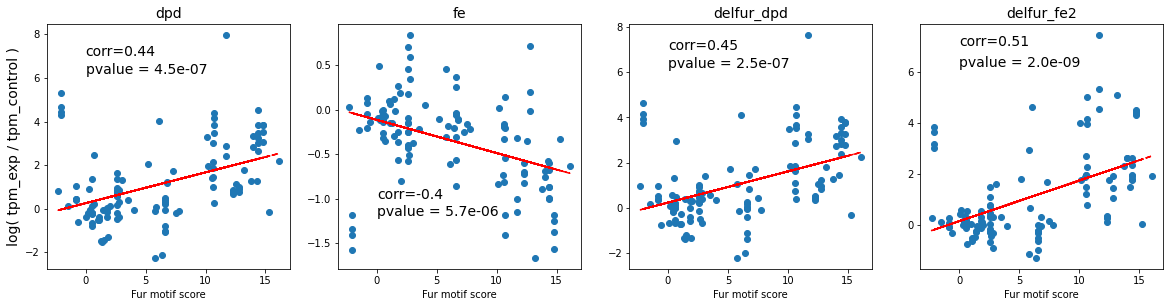

In [44]:
def func(x,a,b):
     return a * x + b
    
fig,axs = plt.subplots(1,4,figsize=(20,4.5))
titles = ['dpd','fe','delfur_dpd','delfur_fe2']
for i in range(4):
    axs[i].scatter(x=fur_chip,y=logtpm_diff[compare_groups[i]])
    axs[i].set_xlabel('Fur motif score')
    popt, pcov = curve_fit(func, fur_chip,  logtpm_diff[compare_groups[i]] )
    axs[i].plot(fur_chip, func(np.array(fur_chip),popt[0],popt[1]),'r--' )
    corr, pval = stats.pearsonr(fur_chip , logtpm_diff[compare_groups[i]])
    corr_txt = str(corr)[0:4]
    pval_txt = str(pval)[0:3] +str(pval)[-4:]
    axs[i].set_title(titles[i],fontsize=14)
    if i in [0,2,3]:
        axs[i].text(0,7,'corr='+corr_txt,fontsize=14)
        axs[i].text(0,6.2,'pvalue = '+pval_txt,fontsize=14)
    else:
        axs[i].text(0,-1,'corr='+corr_txt,fontsize=14)
        axs[i].text(0,-1.2,'pvalue = '+pval_txt,fontsize=14)
axs[0].set_ylabel('log( tpm_exp / tpm_control )',fontsize=14)
fig.savefig('../../../thesis_plots/fur_expression_analysis.svg',dpi=150)

Text(0, 0.5, 'log( tpm_exp / tpm_control )')

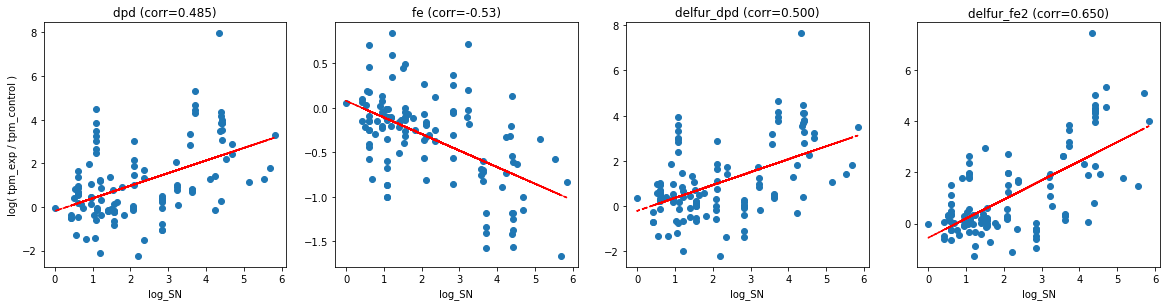

In [65]:
def func(x,a,b):
     return a * x + b
    
fig,axs = plt.subplots(1,4,figsize=(20,4.5))
titles = ['dpd','fe','delfur_dpd','delfur_fe2']
for i in range(4):
    axs[i].scatter(x=fur_sn,y=logtpm_diff[compare_groups[i]])
    axs[i].set_xlabel('log_SN')
    popt, pcov = curve_fit(func, fur_sn,  logtpm_diff[compare_groups[i]] )
    axs[i].plot(fur_sn, func(np.array(fur_sn),popt[0],popt[1]),'r--' )
    corr_txt = str(np.corrcoef( fur_sn , logtpm_diff[compare_groups[i]] )[0,1])[0:5]
    axs[i].set_title(titles[i] + ' (corr='+corr_txt+')')
axs[0].set_ylabel('log( tpm_exp / tpm_control )')

the correlation between motif score and expresson change further validates 
that motif score is the reason of SN ratio distribution ?